In [1]:
import sys
sys.path.insert(0, '../../..')
from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

/home/sharav/src/alpha-discovery-workflow/env/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# loading history with features...
print("reading dataset...")

df = pd.read_csv("/home/sharav/src/project-feature-generation/data/features_BTCUSDT-1m-spot.csv", parse_dates=True, index_col="timestamp")

df

reading dataset...


,Open,High,Low,Close,Volume,m_rsi,m_roc,m_wr,vm_cmf,vm_mfi,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:04:00,4269.26,4269.26,4269.26,4269.26,0.988305,38.387955,-0.440284,-99.185249,0.636822,42.520834,...,-0.999636,-0.687760,0,1.146701,0.880253,16.873143,-13.129643,19.905429,-0.233253,9.252000
2017-08-18 04:05:00,4269.01,4269.01,4269.01,4269.01,0.557007,38.236424,-0.446114,-100.000000,0.626582,40.226107,...,-0.779648,-0.108492,0,1.000000,0.863521,12.400286,-36.856195,22.145429,-0.749626,11.392851
2017-08-18 04:07:00,4269.01,4269.01,4269.01,4269.01,0.591960,38.236424,-0.446346,-100.000000,0.682004,40.226107,...,-0.652191,0.074857,0,1.000000,0.808468,4.594286,-56.833464,24.485714,-1.530110,9.327503
2017-08-18 04:08:00,4269.01,4269.01,4269.01,4269.01,0.339186,38.236424,-0.446346,-100.000000,0.650170,37.361274,...,-0.694225,0.018055,0,1.000000,0.758373,1.512571,-60.862617,24.833143,-1.793890,0.100000
2017-08-18 04:09:00,4269.01,4269.01,4269.01,4269.01,0.320267,38.236424,-0.446346,-100.000000,0.550699,37.361274,...,-0.603405,0.137199,0,1.000000,0.773224,-1.022286,-63.128481,24.633714,-1.973538,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 23:55:00,23149.08,23159.53,23145.27,23149.98,132.988780,60.387263,0.097070,-24.158867,0.084858,64.212159,...,0.676317,-0.042634,1,0.272924,0.906359,-1.866000,63.078745,-27.466857,1.969297,5.891620
2023-01-31 23:56:00,23150.82,23151.77,23126.94,23134.07,186.188000,51.320709,0.055057,-64.406780,0.030088,60.443365,...,0.460276,-0.302288,1,1.355732,0.895144,12.679429,59.425987,-9.325143,1.692659,6.154805
2023-01-31 23:57:00,23133.44,23144.59,23130.01,23140.33,110.498680,54.232391,0.013528,-48.570706,0.016818,65.785846,...,0.042421,-0.676474,0,1.109682,0.900788,6.424000,57.216924,-13.761143,1.552703,6.225420


In [3]:
# Helper functions

from pathlib import PurePath, Path
import sys
import time
import warnings
import datetime as dt
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json
import pandas as pd
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import mplfinance as mpf

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')


class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out


def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0


def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps


def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1


def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out


def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking level; 
                  element 1 is stop loss level.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events


def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret       = out_df.loc[date_time, 'ret' ]
        target    = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df


def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret' ] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df


def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

def cci_indicator(df_, length=40):
    hlc3 = (df_['High']+df_['Low']+df_['Close'])/3
    sma  = hlc3.rolling(length).mean()
    mad  = hlc3.rolling(length).apply(lambda x: pd.Series(x).mad())
    cci  = (hlc3-sma)/(0.015*mad)
    cci_smooth = cci.ewm(span=5, min_periods=0, adjust=False, ignore_na=False).mean()
    return cci, cci_smooth

In [4]:
side_features = []
with open("../model/features_side.txt", "r") as f:
    side_features = f.readlines()[0].strip().split()

side_features

['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']

In [5]:
import joblib

side_rf = joblib.load("../model/btcusdt_rf_side.save")

side_rf

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)

In [6]:
w                     = 600 # 9~10 hours
volatility_scaler     = 0.6
holding_period        = 2.0

df['volatility_tpsl'] = get_daily_volatility(close=df['Close'], lookback=w)
cusum_events          = get_t_events(df['Close'], threshold=df['volatility_tpsl'].mean()*float(volatility_scaler))
vertical_barriers     = add_vertical_barrier(t_events=cusum_events, close=df['Close'], num_days=float(holding_period))

Applying Symmetric CUSUM filter.


100%|██████████| 2832260/2832260 [02:01<00:00, 23290.72it/s]


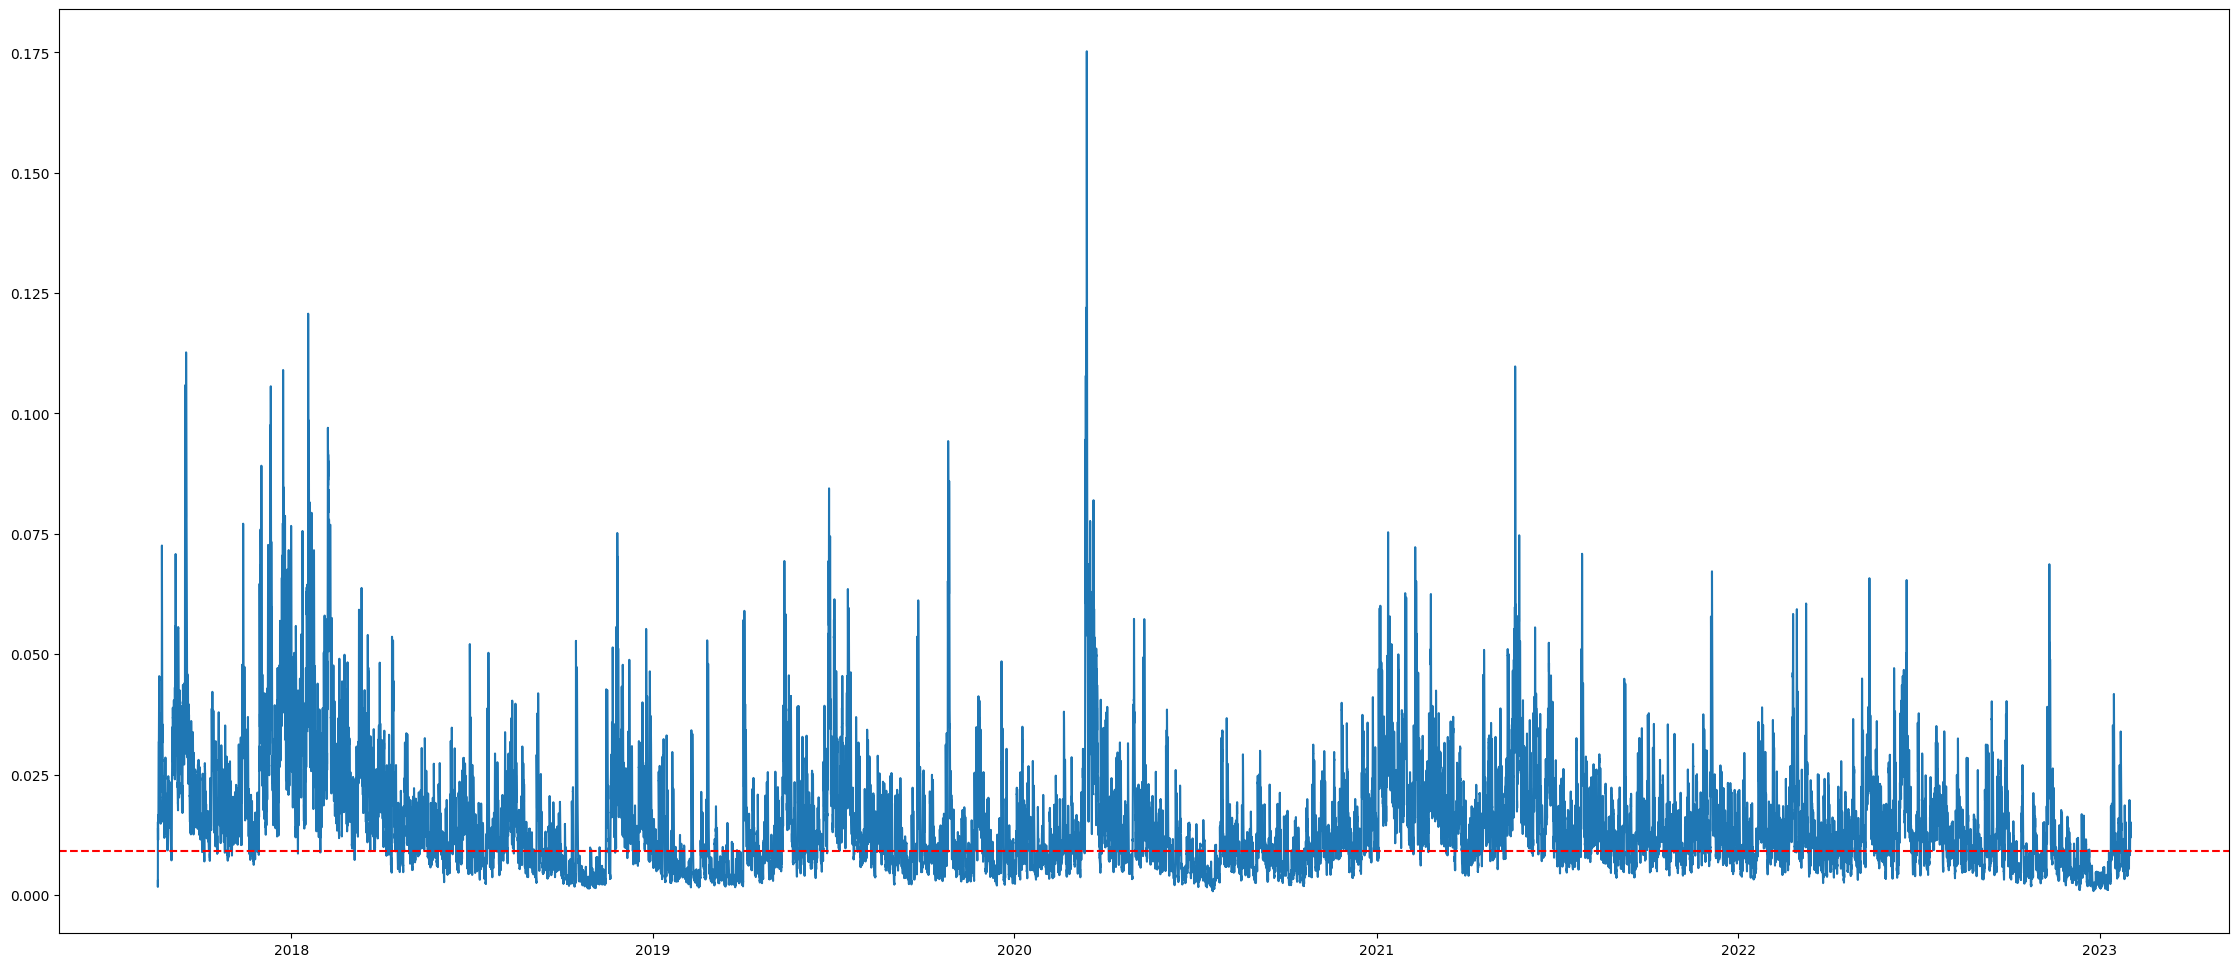

In [7]:
f, axs=plt.subplots(1, figsize=(28,12))
axs.plot(df['volatility_tpsl'])
axs.axhline(df['volatility_tpsl'].mean()*volatility_scaler, ls='--', color='r')

In [8]:
cusum_events

DatetimeIndex(['2017-08-18 04:46:00', '2017-08-18 05:17:00',
               '2017-08-18 05:30:00', '2017-08-18 05:44:00',
               '2017-08-18 05:45:00', '2017-08-18 05:52:00',
               '2017-08-18 06:34:00', '2017-08-18 06:41:00',
               '2017-08-18 06:42:00', '2017-08-18 06:57:00',
               ...
               '2023-01-30 14:45:00', '2023-01-30 18:04:00',
               '2023-01-30 19:09:00', '2023-01-30 19:10:00',
               '2023-01-30 20:25:00', '2023-01-30 23:51:00',
               '2023-01-31 07:46:00', '2023-01-31 13:39:00',
               '2023-01-31 21:17:00', '2023-01-31 22:48:00'],
              dtype='datetime64[ns]', length=53944, freq=None)

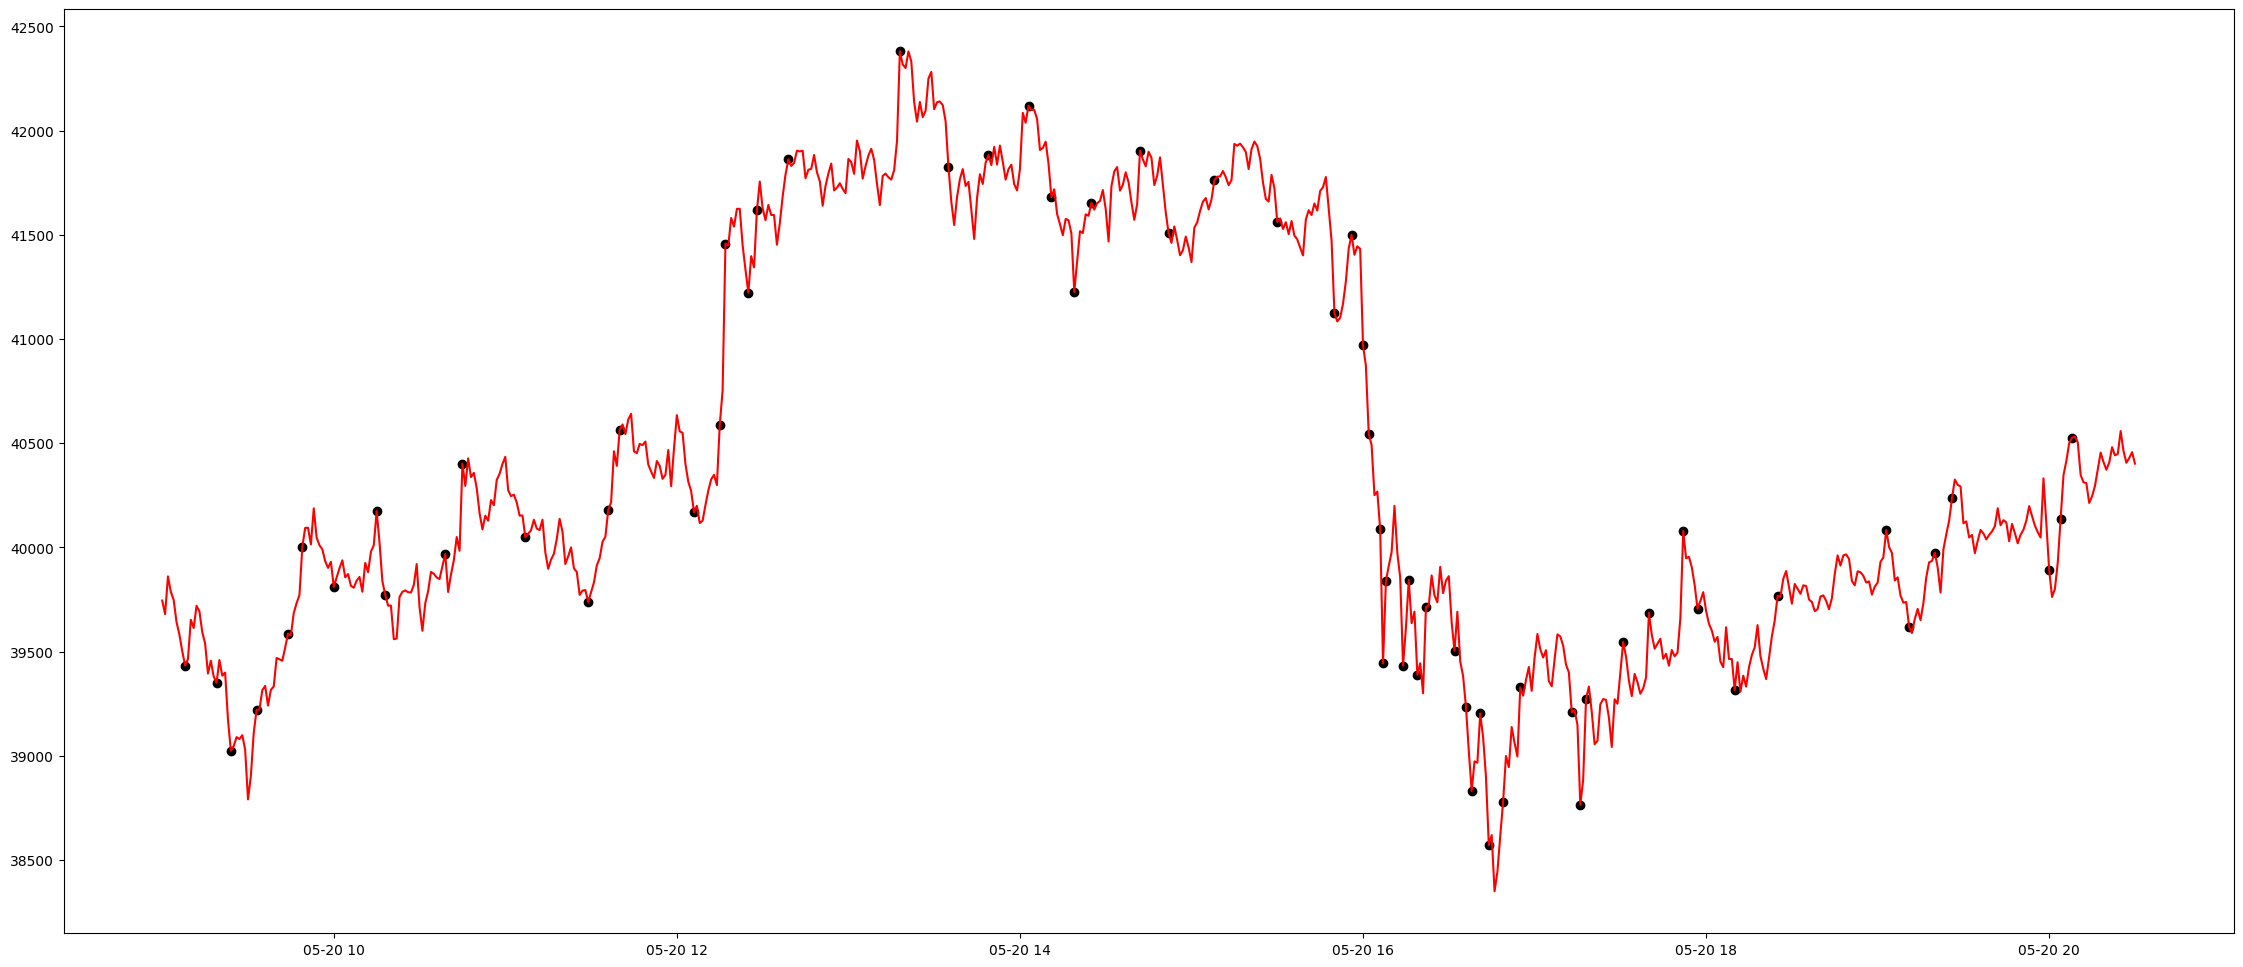

In [9]:
_, axs = plt.subplots(1, figsize=(28, 12))

closing   = df['Close']
startdate = pd.to_datetime("2021-05-20 09:00:00")
enddate   = pd.to_datetime("2021-05-20 20:30:00")
axs.plot(closing.loc[(closing.index>=startdate)&(closing.index<=enddate)], color='r')
closing_ = closing[cusum_events]
closing_ = closing_.loc[(closing_.index>=startdate)&(closing_.index<=enddate)]
axs.scatter(closing_.index, closing_, color='k')

In [10]:
dataset_df = df.loc[cusum_events][side_features].copy()
dataset_df

,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180
2017-08-18 04:46:00,-0.001218,0.003299,6.048173e+10,7.630623,0.174129
2017-08-18 05:17:00,0.008013,0.003154,5.684243e+09,7.534065,0.209282
2017-08-18 05:30:00,0.010719,0.003824,2.009352e+10,7.535200,0.307650
2017-08-18 05:44:00,0.012907,0.004756,-8.891517e+08,7.996339,0.268879
2017-08-18 05:45:00,0.002297,0.004606,-2.158352e+10,8.204693,0.264811
...,...,...,...,...,...
2023-01-30 23:51:00,-0.003098,0.001804,1.469917e+08,23.679453,0.105302
2023-01-31 07:46:00,0.004964,0.001832,1.179817e+08,13.769310,0.069152
2023-01-31 13:39:00,0.007960,0.002299,2.401999e+08,15.356582,0.111374
2023-01-31 21:17:00,-0.010663,0.003351,-1.223874e+09,16.081987,-0.095688


In [11]:
dataset_df['side'] = side_rf.predict(dataset_df[side_features])
dataset_df['side'].value_counts()

 1.0    28698
-1.0    25246
Name: side, dtype: int64

In [12]:
dataset_df.loc[dataset_df['side']==-1, 'prob'] = side_rf.predict_proba(dataset_df[dataset_df['side']==-1][side_features])[:,0]
dataset_df.loc[dataset_df['side']== 1, 'prob'] = side_rf.predict_proba(dataset_df[dataset_df['side']== 1][side_features])[:,1]

<AxesSubplot: >

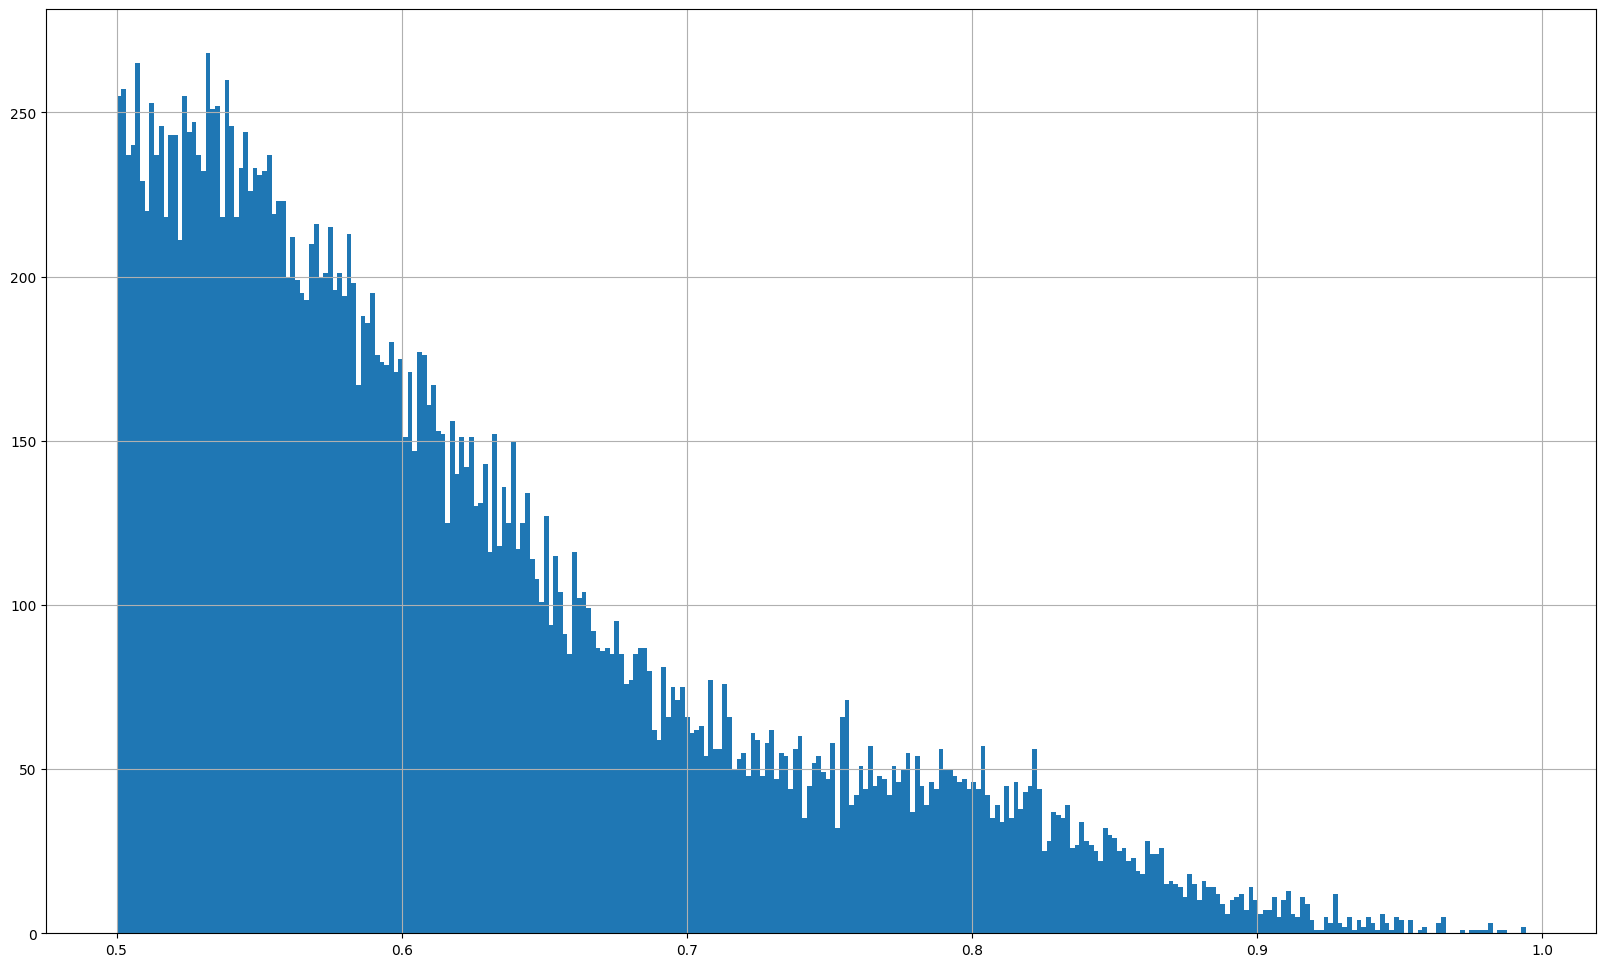

In [13]:
dataset_df[dataset_df['side']==-1]['prob'].hist(bins=300)

<AxesSubplot: >

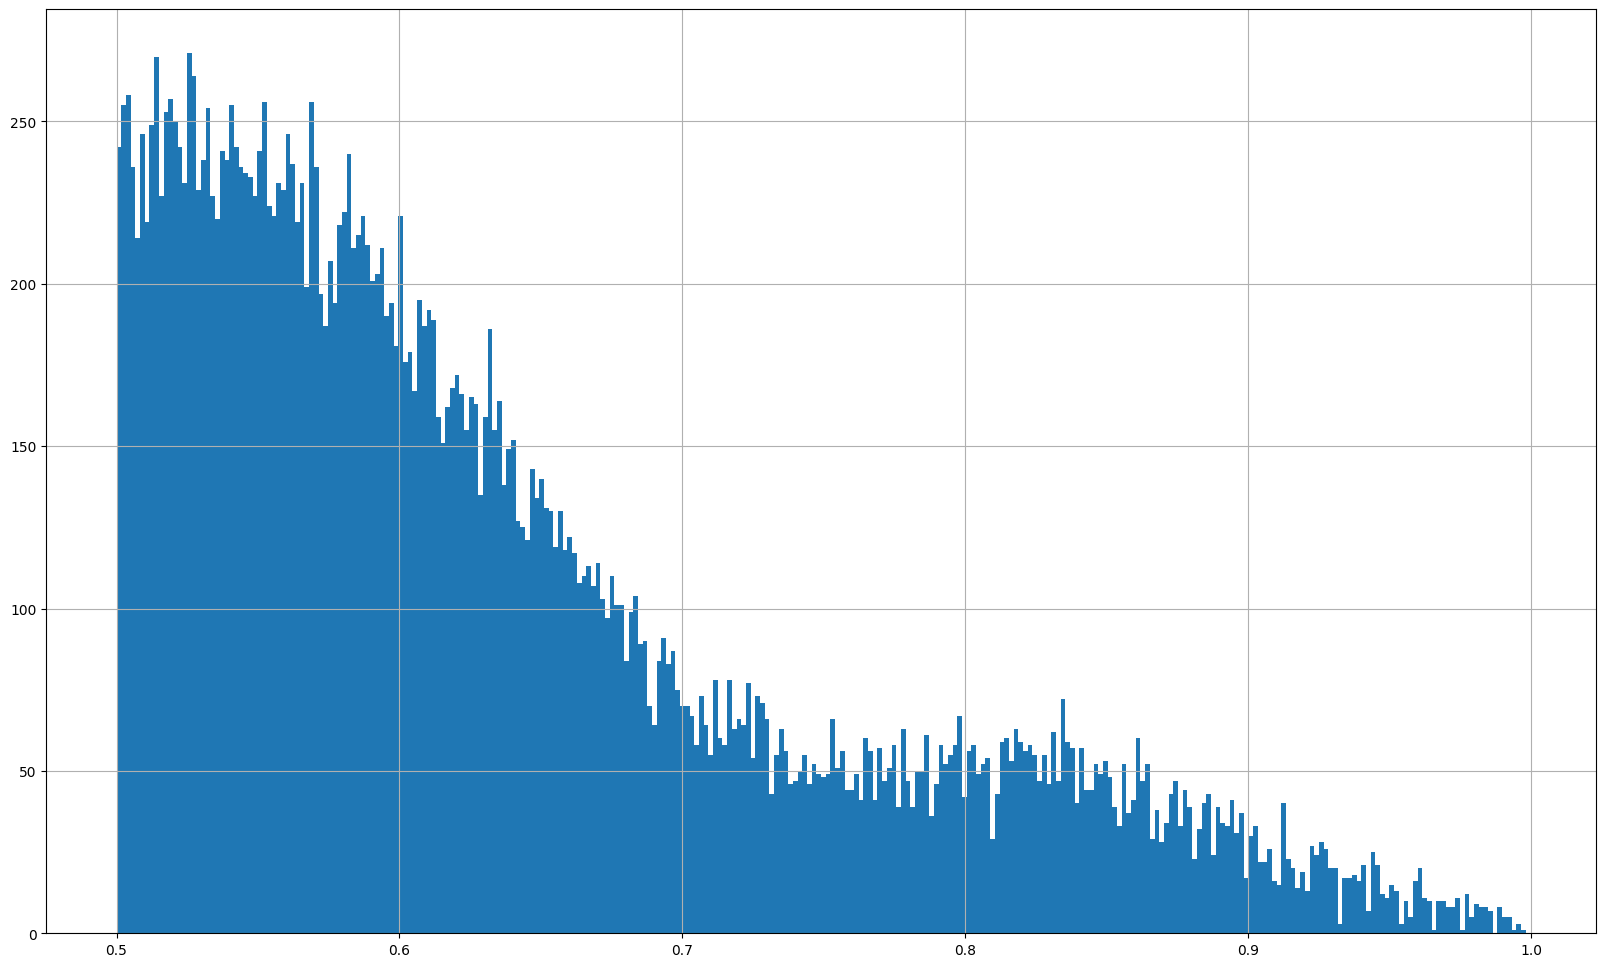

In [14]:
dataset_df[dataset_df['side']== 1]['prob'].hist(bins=300)

In [15]:
prob_threshold   = 0.7
predicted_events = dataset_df[dataset_df['prob']>=prob_threshold].index

predicted_events

DatetimeIndex(['2017-08-18 10:50:00', '2017-08-18 12:45:00',
               '2017-08-18 12:47:00', '2017-08-18 13:25:00',
               '2017-08-18 13:44:00', '2017-08-18 14:33:00',
               '2017-08-18 17:02:00', '2017-08-18 19:11:00',
               '2017-08-18 19:25:00', '2017-08-18 20:38:00',
               ...
               '2023-01-14 18:27:00', '2023-01-16 15:14:00',
               '2023-01-17 00:49:00', '2023-01-18 17:06:00',
               '2023-01-21 10:26:00', '2023-01-22 19:59:00',
               '2023-01-23 19:42:00', '2023-01-24 14:01:00',
               '2023-01-25 15:46:00', '2023-01-30 01:20:00'],
              dtype='datetime64[ns]', length=11878, freq=None)

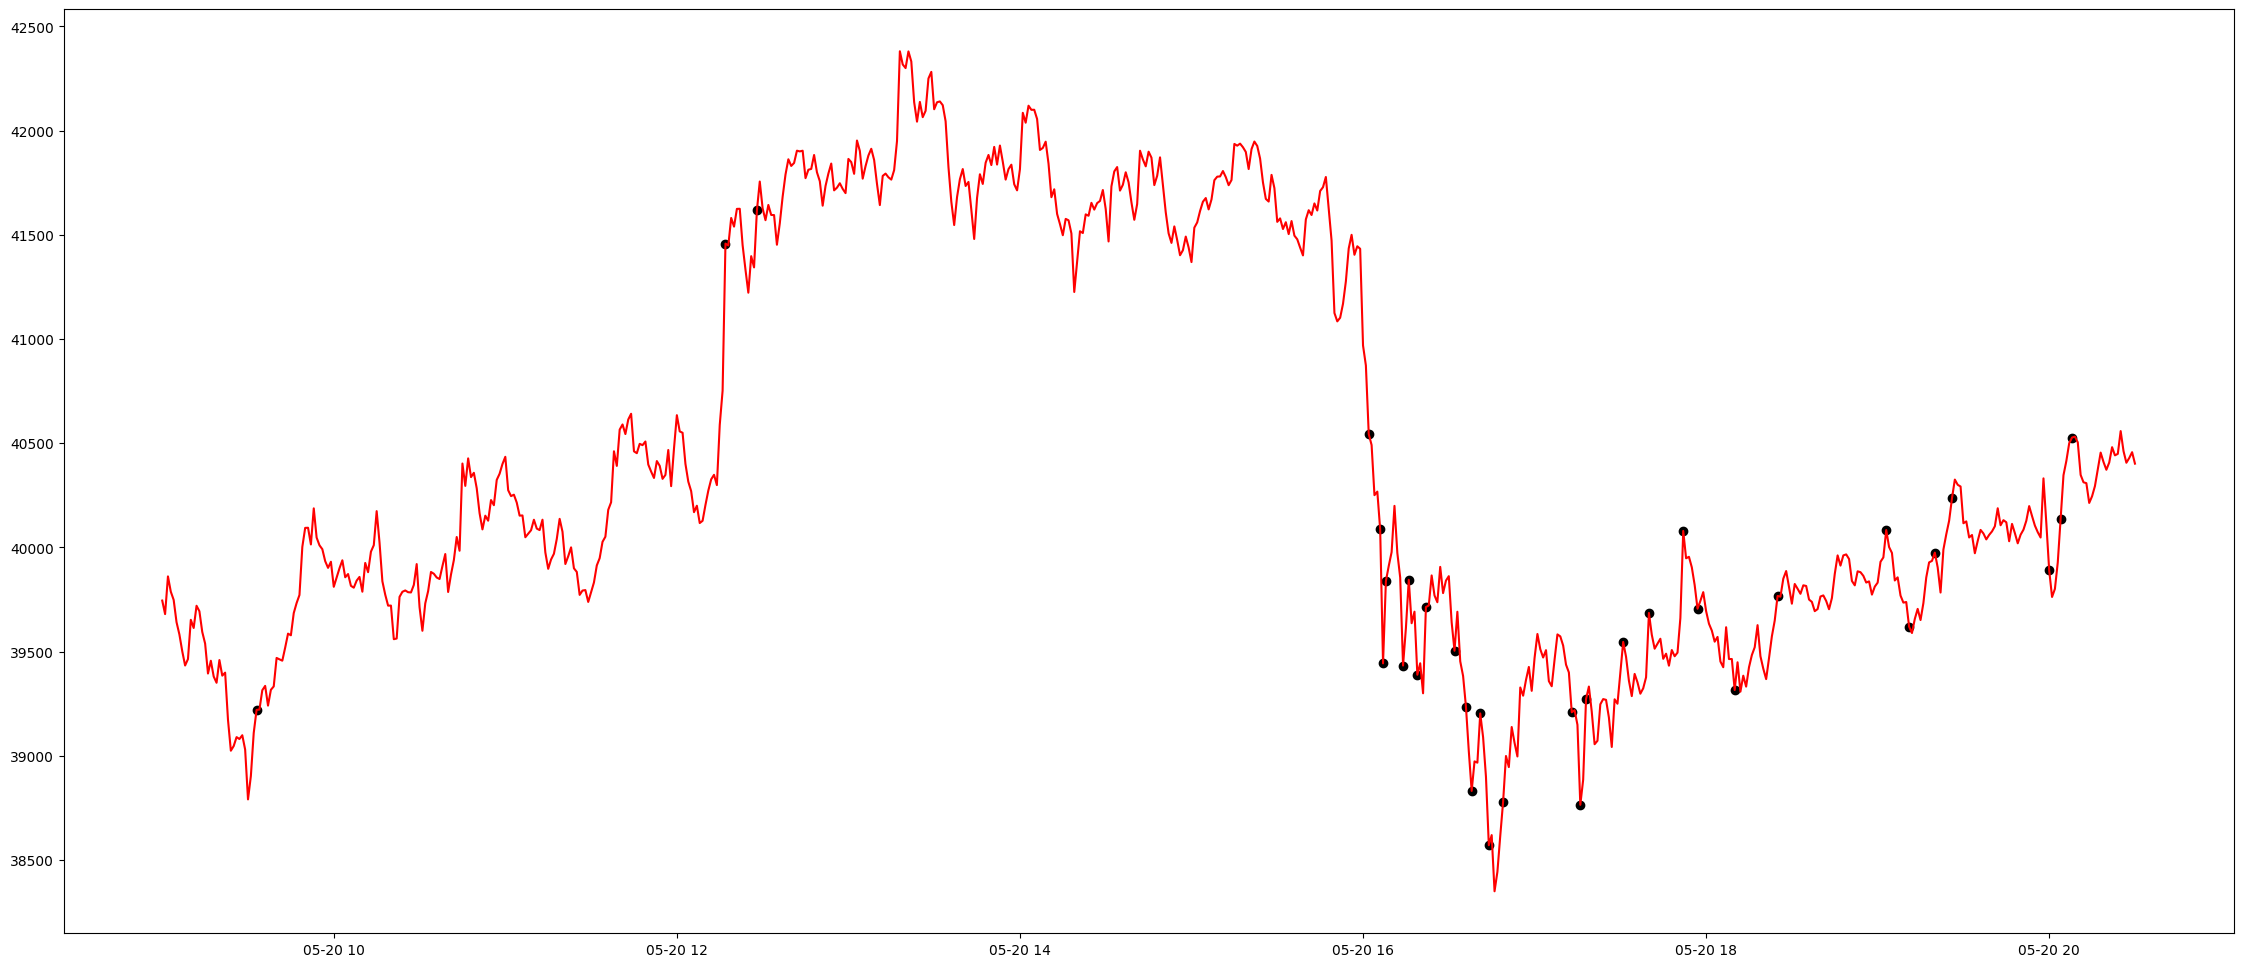

In [16]:
_, axs = plt.subplots(1, figsize=(28, 12))

closing   = df['Close']
startdate = pd.to_datetime("2021-05-20 09:00:00")
enddate   = pd.to_datetime("2021-05-20 20:30:00")
axs.plot(closing.loc[(closing.index>=startdate)&(closing.index<=enddate)], color='r')
closing_ = closing[predicted_events]
closing_ = closing_.loc[(closing_.index>=startdate)&(closing_.index<=enddate)]
axs.scatter(closing_.index, closing_, color='k')

In [17]:
dataset_df

,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180,side,prob
2017-08-18 04:46:00,-0.001218,0.003299,6.048173e+10,7.630623,0.174129,-1.0,0.644723
2017-08-18 05:17:00,0.008013,0.003154,5.684243e+09,7.534065,0.209282,-1.0,0.545252
2017-08-18 05:30:00,0.010719,0.003824,2.009352e+10,7.535200,0.307650,-1.0,0.673977
2017-08-18 05:44:00,0.012907,0.004756,-8.891517e+08,7.996339,0.268879,1.0,0.552539
2017-08-18 05:45:00,0.002297,0.004606,-2.158352e+10,8.204693,0.264811,1.0,0.537925
...,...,...,...,...,...,...,...
2023-01-30 23:51:00,-0.003098,0.001804,1.469917e+08,23.679453,0.105302,-1.0,0.549582
2023-01-31 07:46:00,0.004964,0.001832,1.179817e+08,13.769310,0.069152,-1.0,0.611194
2023-01-31 13:39:00,0.007960,0.002299,2.401999e+08,15.356582,0.111374,-1.0,0.523690
2023-01-31 21:17:00,-0.010663,0.003351,-1.223874e+09,16.081987,-0.095688,1.0,0.511284


In [18]:
df['primary_side'] = np.nan
df['primary_prob'] = np.nan
df['primary_side'] = dataset_df['side']
df['primary_prob'] = dataset_df['prob']

In [19]:
df['primary_side'].value_counts()

 1.0    28698
-1.0    25246
Name: primary_side, dtype: int64

In [20]:
prob_threshold = 0.7
df['is_signal'] = False
df.loc[df['primary_prob']>=prob_threshold, 'is_signal'] = True

df[df['is_signal']==True]['primary_side'].value_counts()

 1.0    6930
-1.0    4948
Name: primary_side, dtype: int64

In [21]:
# TBL labeling training set 

RR         = 1.0
sl_target  = 1.0

min_ret    = 0.001 # minimum return of 0.1%

long_ptsl  = [round(sl_target*RR, 2), sl_target]
short_ptsl = [round(sl_target*RR, 2), sl_target]

print(f"{RR} -> {long_ptsl}")


long_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[(df['primary_side']==1)&(df['is_signal']==True)].index,
                                    pt_sl                  = long_ptsl,
                                    target                 = df['volatility_tpsl'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[(df['primary_side']==1)&(df['is_signal']==True)]['primary_side']
                                    )

short_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[(df['primary_side']==-1)&(df['is_signal']==True)].index,
                                    pt_sl                  = short_ptsl,
                                    target                 = df['volatility_tpsl'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[(df['primary_side']==-1)&(df['is_signal']==True)]['primary_side']
                                    )

triple_barrier_events = pd.concat([long_triple_barrier_events, short_triple_barrier_events])
triple_barrier_events = triple_barrier_events.sort_index()
triple_barrier_events.dropna(inplace=True)


labels = get_bins(triple_barrier_events, df['Close'])
labels.dropna(inplace=True)

labels = labels.sort_index()
labels = labels[~labels.index.duplicated(keep='last')]

1.0 -> [1.0, 1.0]


2023-02-22 14:48:02.170340 100.0% apply_pt_sl_on_t1 done after 0.03 minutes. Remaining 0.0 minutes.
2023-02-22 14:48:04.234979 100.0% apply_pt_sl_on_t1 done after 0.03 minutes. Remaining 0.0 minutes.


In [22]:
labels

,ret,trgt,bin,side
2017-08-19 04:25:00,0.019470,0.005146,1,1.0
2017-08-19 04:27:00,0.006295,0.005555,1,-1.0
2017-08-19 04:35:00,0.008544,0.006920,1,1.0
2017-08-19 04:43:00,0.017634,0.007179,1,-1.0
2017-08-19 04:59:00,0.013689,0.008802,1,1.0
...,...,...,...,...
2023-01-22 19:59:00,-0.015007,0.013473,0,1.0
2023-01-23 19:42:00,0.006542,0.006306,1,1.0
2023-01-24 14:01:00,0.006608,0.006599,0,1.0
2023-01-25 15:46:00,0.004818,0.004459,1,1.0


In [23]:
labels['bin'].value_counts()

1    7519
0    4349
Name: bin, dtype: int64

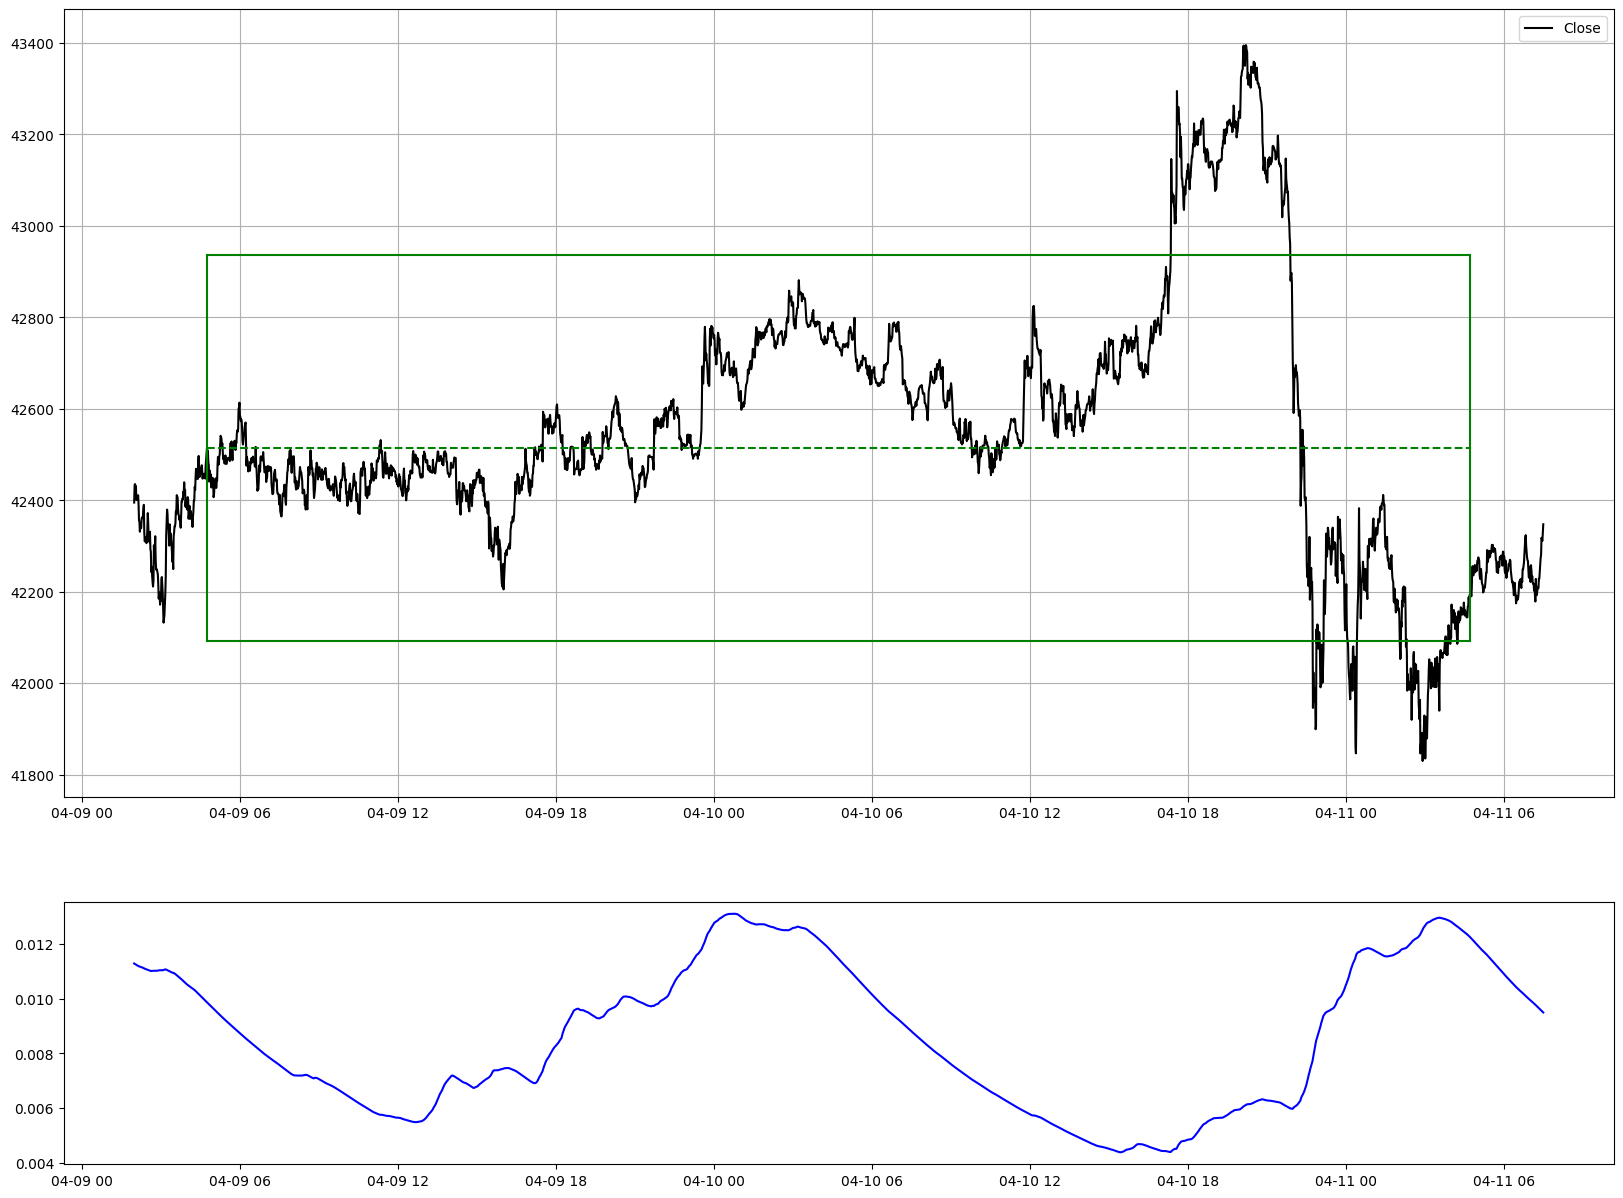

In [25]:
# Plotting buy side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==1)].sample()
selected_date = label.index[0]

duration_seconds = 172800  # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_tp = close_price+delta_upper
price_sl = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='g')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='g')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

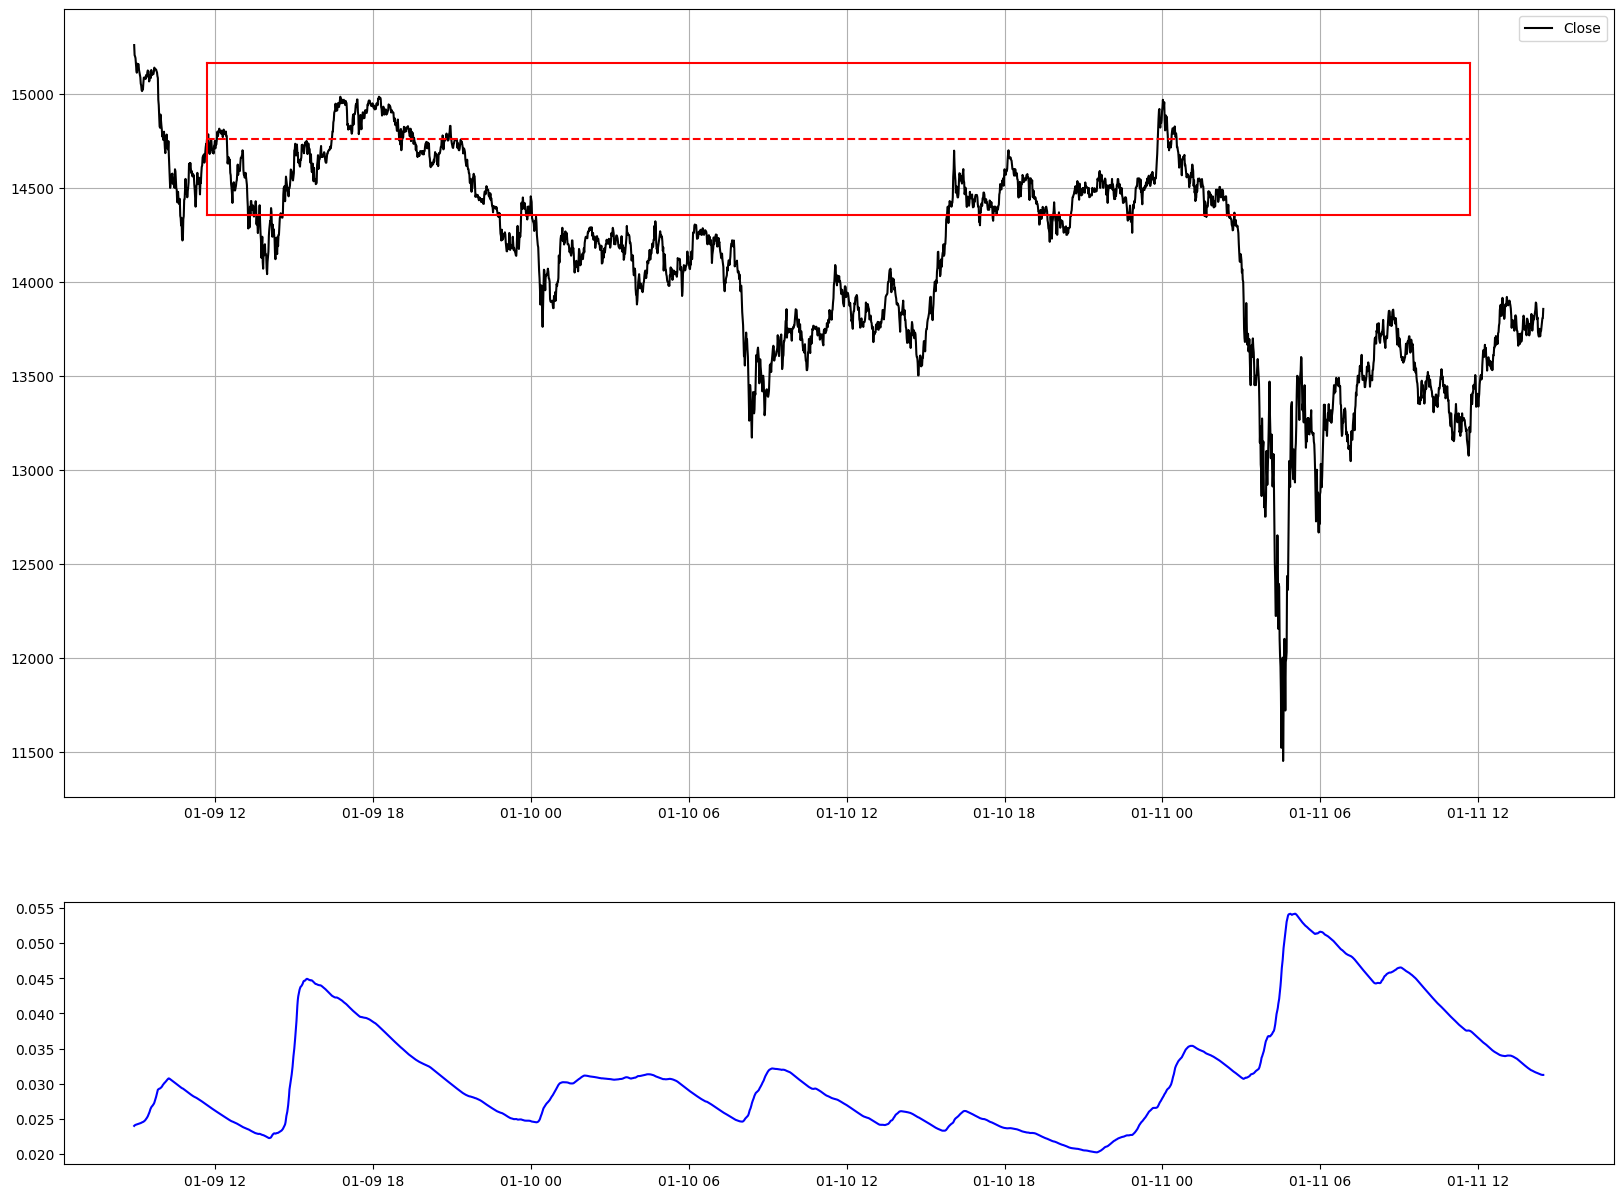

In [26]:
# Plotting sell side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==-1)].sample()
selected_date = label.index[0]

duration_seconds = 172800 # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_sl = close_price+delta_upper
price_tp = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='r')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='r')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

In [27]:
trainable_features = [feature for feature in list(df.columns) if not feature in ["position", "Open", "High", "Low", "Close", "primary_side", "primary_prob", "is_signal"]]
print(trainable_features)

['Volume', 'm_rsi', 'm_roc', 'm_wr', 'vm_cmf', 'vm_mfi', 'vm_fi', 'vm_eom', 'vl_bbp', 'vl_atr', 't_macdd', 't_trix', 't_cci', 't_dpo', 't_kst', 't_adx', 'log_ret', 'momentum_1', 'momentum_2', 'momentum_3', 'momentum_4', 'momentum_5', 'momentum_6', 'volatility_3', 'volatility_6', 'volatility_10', 'volatility_25', 'volatility_30', 'volatility_45', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_lag_1', 'log_lag_2', 'log_lag_3', 'log_lag_4', 'log_lag_5', 'log_lag_6', 'log_lag_7', 'm_rsi_6', 'm_roc_6', 'm_wr_6', 'vm_cmf_6', 'vm_mfi_6', 'vm_fi_6', 'vm_eom_6', 'vl_bbp_6', 'vl_atr_6', 't_macd_12_6', 't_trix_6', 't_cci_6', 't_dpo_6', 't_adx_6', 'm_rsi_12', 'm_roc_12', 'm_wr_12', 'vm_cmf_12', 'vm_mfi_12', 'vm_fi_12', 'vm_eom_12', 'vl_bbp_12', 'vl_atr_12', 't_macd_24_12', 't_trix_12', 't_cci_12', 't_dpo_12', 't_adx_12', 'm_rsi_25', 'm_roc_25', 'm_wr_25', 'vm_cmf_25', 'vm_mfi_25', 'vm_fi_25', 'vm_eom_25', 'vl_bbp_25', 'vl_atr_25', 't_macd_50_25', 't_trix_25', 't_cci_25'

In [28]:
labels

,ret,trgt,bin,side
2017-08-19 04:25:00,0.019470,0.005146,1,1.0
2017-08-19 04:27:00,0.006295,0.005555,1,-1.0
2017-08-19 04:35:00,0.008544,0.006920,1,1.0
2017-08-19 04:43:00,0.017634,0.007179,1,-1.0
2017-08-19 04:59:00,0.013689,0.008802,1,1.0
...,...,...,...,...
2023-01-22 19:59:00,-0.015007,0.013473,0,1.0
2023-01-23 19:42:00,0.006542,0.006306,1,1.0
2023-01-24 14:01:00,0.006608,0.006599,0,1.0
2023-01-25 15:46:00,0.004818,0.004459,1,1.0


In [29]:
meta_labels = labels.copy()
meta_labels['bin'] = labels['bin']
meta_labels['bin'].value_counts()

1    7519
0    4349
Name: bin, dtype: int64

In [30]:
meta_labels_train = meta_labels[:"2022-01-12"]
meta_labels_oos   = meta_labels["2022-01-14":]

In [31]:
# ML friendly dataset for meta labels

X_train = df.loc[meta_labels_train.index][trainable_features].copy()
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
y_train = meta_labels_train['bin']

X_test  = df.loc[meta_labels_oos.index][trainable_features].copy()
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)
y_test  = meta_labels_oos['bin']

<AxesSubplot: >

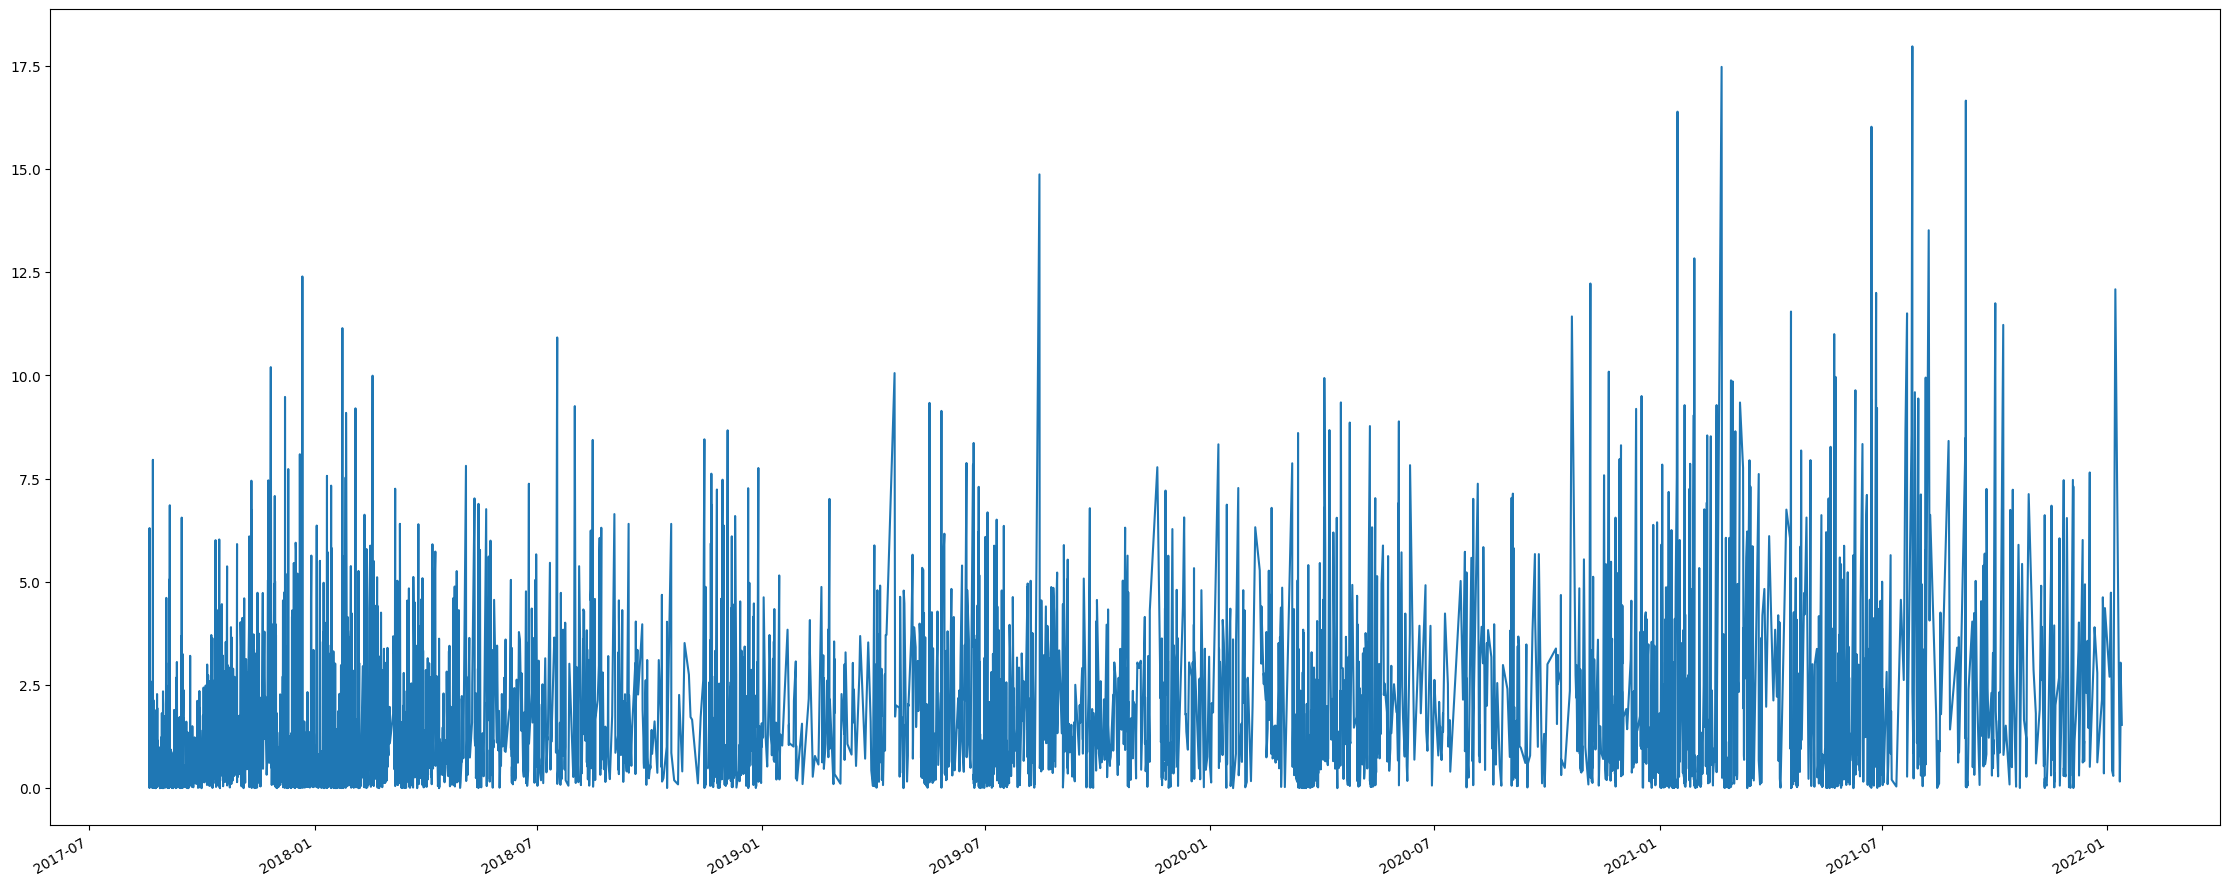

In [32]:
from mlfinlab.sample_weights import get_weights_by_return

return_based_sample_weights_meta = get_weights_by_return(
    triple_barrier_events.loc[X_train.index], 
    df.loc[X_train.index, 'Close'],
    num_threads=1)

_, axs = plt.subplots(1, figsize=(28,12))
return_based_sample_weights_meta.plot(ax=axs)

In [33]:
from sklearn.ensemble  import RandomForestClassifier, BaggingClassifier
from sklearn.tree      import DecisionTreeClassifier
from mlfinlab.ensemble import SequentiallyBootstrappedBaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

In [34]:
# Clustering features
#
# Substitution effect
# When more than one features share the same predictive information
# substitution effect can bias the results of feature importance
# In the case MDI, the importance would be halved.
# In order to deal with this, we have two methods :
#   1. Orthogonalization   : 
#      Generate PCA components features estimate importance on them
#   2. Clustering features :  
#      Cluster features and estimate importance of cluster
#
# The method 1, may reduce the substitution effects, but it has 3 caveats
#   1. Non linear relation redundant features still cause substitution effects
#   2. May not have intuitive explanation
#   3. Defined by eigen vectors, which may not necessary maximize output
# 
# The method 2, it involves the two steps :
#   1. Features Clustering
#      ONC algorithm used, quality of clustering is checked by silhouette scores
#      For each cluster you regress on the other cluster. 
#      Then you can use residual instead.
#   2. Clustered Importance     
#      We estimate importance of each cluster rather than individual features.
# 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def _fix_corr(corr):
    corr[corr > 1] = 1
    corr[corr < -1] = -1
    return corr.fillna(0)

def corr_metric(corr, use_abs=False):
    corr = _fix_corr(corr)
    if use_abs:
        return np.sqrt(1 - np.abs(corr))
    else:
        return np.sqrt(0.5 * (1 - corr))

_eps = 1e-16

def cluster_kmeans_base(corr0, max_num_clusters=10, min_num_clusters=4, n_init=10, debug=False):
    dist = corr_metric(corr0, False)
    silh = None
    kmeans = None
    q_val = None
    max_num_clusters = min(max_num_clusters, int(np.floor(dist.shape[0]/2)))
    min_num_clusters = max(2, min_num_clusters)
    for _ in range(n_init):
        for n_clusters in range(min_num_clusters, max_num_clusters + 1):
            kmeans_ = KMeans(n_clusters=n_clusters, n_init=1)
            kmeans_ = kmeans_.fit(dist.values)
            silh_ = silhouette_samples(dist.values, kmeans_.labels_)
            q_val_ = silh_.mean() / max(silh_.std(), _eps)
            if q_val is None or q_val_ > q_val:
                silh = silh_
                kmeans = kmeans_
                q_val = q_val_
                if debug:
                    print(kmeans)
                    print(q_val, silh)
                    silhouette_avg = silhouette_score(dist.values, kmeans_.labels_)
                    print(f"For n_clusters={n_clusters}, slih_std: {silh_.std()} The average silhouette_score is : {silhouette_avg}")
                    print("********")
    new_idx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[new_idx]
    corr1 = corr1.iloc[:, new_idx]
    clstrs = {i:corr0.columns[np.where(kmeans.labels_ == i)[0]].tolist() for i in np.unique(kmeans.labels_)}
    silh = pd.Series(silh, index=dist.index)
    return corr1, clstrs, silh

In [35]:
# Clusters

clusters = {0: ['HT_DCPHASE'], 1: ['HT_SINE_leadsine'], 2: ['m_wr', 'm_wr_6', 'vl_bbp_6', 't_cci_6', 'm_wr_12', 'vl_bbp_12', 't_cci_12', 'm_wr_25', 'close_sign', 'BOP', 'CCI', 'STOCH_slowk', 'STOCHF_fastk', 'STOCHF_fastd', 'STOCHRSI_fastk', 'WILLR'], 3: ['autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'HT_DCPERIOD', 'HT_TRENDMODE', 'BETA', 'CORREL'], 4: ['high_log', 'close_log', 'sma_6_log', 'sma_12_log', 'sma_25_log', 'sma_50_log', 'sma_110_log', 'sma_220_log', 'sma_440_log'], 5: ['vm_eom', 'vm_eom_6', 'vm_eom_12', 'vm_eom_25', 'vm_eom_50', 'vm_eom_90', 'vm_eom_120', 'vm_eom_180', 'vm_eom_300', 'vm_eom_400'], 6: ['vm_cmf', 'vm_cmf_12', 'vm_cmf_25', 'vm_cmf_50', 'close_plus_minus_20', 'close_plus_minus_40'], 7: ['m_roc', 't_trix_6', 'm_roc_12', 'm_roc_25', 'ma_25', 'ma_50', 'ADOSC'], 8: ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MIDPOINT', 'SMA', 'T3', 'TRIMA', 'WMA', 'LINEARREG_INTERCEPT'], 9: ['vl_atr', 'vl_atr_6', 'vl_atr_12', 'vl_atr_25', 'ATR', 'TRANGE', 'STDDEV'], 10: ['t_macd_100_50', 't_macd_180_90', 't_macd_240_120', 't_macd_360_180', 't_macd_600_300', 't_macd_800_400', 'APO', 'MACD_macd', 'MACD_macdsignal'], 11: ['vm_fi', 'vm_fi_6', 'vm_fi_12', 'vm_fi_25', 'vm_fi_50', 'vm_fi_90', 'vm_fi_120', 'vm_fi_180', 'vm_fi_300', 'vm_fi_400'], 12: ['m_roc_90', 'm_roc_120', 'm_roc_180', 'm_roc_300', 'm_roc_400', 'ma_220', 'ma_440'], 13: ['log_ret', 'momentum_1', 'momentum_2'], 14: ['t_macdd', 't_macd_12_6', 't_macd_24_12', 't_macd_50_25', 'MACD_macdhist', 'MOM', 'LINEARREG_SLOPE'], 15: ['volatility_3', 'volatility_6', 'volatility_10', 'volatility_25', 'volatility_30', 'volatility_45', 'daily_volatility_15', 'daily_volatility_30', 'daily_volatility_50', 'daily_volatility_120', 'daily_volatility_240', 'NATR', 'volatility_tpsl'], 16: ['t_trix_90', 't_trix_120', 't_trix_180'], 17: ['m_rsi_25', 'vm_mfi_25', 'm_rsi_50', 't_cci_50', 'm_wr_90', 'vl_bbp_90', 't_cci_90', 'm_wr_120', 'vl_bbp_120', 't_cci_120', 'm_wr_180', 'vl_bbp_180'], 18: ['t_adx_50', 't_adx_90', 't_adx_120', 't_adx_180', 't_adx_300', 't_adx_400'], 19: ['t_adx', 't_adx_12', 't_adx_25', 'ADX', 'ADXR'], 20: ['AROON_aroondown', 'MINUS_DI'], 21: ['momentum_3', 'momentum_4', 'momentum_5', 'momentum_6', 'm_roc_6', 'ma_6', 'ma_12'], 22: ['log_lag_3', 'log_lag_4', 'log_lag_5', 'log_lag_6', 'log_lag_7', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature'], 23: ['vm_mfi_180', 'vm_mfi_300', 'vm_mfi_400'], 24: ['vm_cmf_6', 'stochastic_k', 'stochastic_d', 'close_plus_minus_5', 'STOCH_slowd', 'STOCHRSI_fastd'], 25: ['t_trix', 't_kst', 't_trix_12', 'm_roc_50', 'ma_110'], 26: ['Volume', 'volume_log', 'volume_norm', 'volume_norm_log'], 27: ['t_dpo', 't_dpo_25', 't_dpo_50'], 28: ['t_dpo_6', 't_dpo_12', 'BBANDS_middleband', 'TEMA', 'LINEARREG'], 29: ['vm_mfi_50', 'm_rsi_90', 'vm_mfi_90', 'm_rsi_120', 'vm_mfi_120', 'm_rsi_180', 't_cci_180', 'm_rsi_300', 'm_wr_300', 'vl_bbp_300', 't_cci_300', 'm_rsi_400', 'm_wr_400', 'vl_bbp_400', 't_cci_400'], 30: ['t_adx_6', 'DX'], 31: ['vm_cmf_90', 'vm_cmf_120', 'vm_cmf_180', 'vm_cmf_300', 'vm_cmf_400'], 32: ['vl_atr_50', 'vl_atr_90', 'vl_atr_120', 'vl_atr_180', 'vl_atr_300', 'vl_atr_400', 'PLUS_DM'], 33: ['t_trix_300', 't_trix_400'], 34: ['sma_6', 'sma_12', 'sma_25', 'sma_50', 'sma_110', 'sma_220', 'sma_440', 'AD'], 35: ['t_trix_25', 't_trix_50', 'TRIX'], 36: ['price_volatility_norm', 'price_volatility_norm_log'], 37: ['BBANDS_upperband', 'MINUS_DM'], 38: ['log_lag_1', 'log_lag_2', 'HT_SINE_sine'], 39: ['m_rsi', 'vl_bbp', 't_cci', 'm_rsi_6', 'm_rsi_12', 'vl_bbp_25', 't_cci_25', 'm_wr_50', 'vl_bbp_50', 'RSI'], 40: ['BBANDS_lowerband', 'OBV'], 41: ['t_dpo_90', 't_dpo_120', 't_dpo_180', 't_dpo_300', 't_dpo_400'], 42: ['vm_mfi', 'vm_mfi_6', 'vm_mfi_12', 'AROON_aroonup', 'AROONOSC', 'MFI', 'PLUS_DI', 'ULTOSC', 'LINEARREG_ANGLE']}
print(clusters)

{0: ['HT_DCPHASE'], 1: ['HT_SINE_leadsine'], 2: ['m_wr', 'm_wr_6', 'vl_bbp_6', 't_cci_6', 'm_wr_12', 'vl_bbp_12', 't_cci_12', 'm_wr_25', 'close_sign', 'BOP', 'CCI', 'STOCH_slowk', 'STOCHF_fastk', 'STOCHF_fastd', 'STOCHRSI_fastk', 'WILLR'], 3: ['autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'HT_DCPERIOD', 'HT_TRENDMODE', 'BETA', 'CORREL'], 4: ['high_log', 'close_log', 'sma_6_log', 'sma_12_log', 'sma_25_log', 'sma_50_log', 'sma_110_log', 'sma_220_log', 'sma_440_log'], 5: ['vm_eom', 'vm_eom_6', 'vm_eom_12', 'vm_eom_25', 'vm_eom_50', 'vm_eom_90', 'vm_eom_120', 'vm_eom_180', 'vm_eom_300', 'vm_eom_400'], 6: ['vm_cmf', 'vm_cmf_12', 'vm_cmf_25', 'vm_cmf_50', 'close_plus_minus_20', 'close_plus_minus_40'], 7: ['m_roc', 't_trix_6', 'm_roc_12', 'm_roc_25', 'ma_25', 'ma_50', 'ADOSC'], 8: ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MIDPOINT', 'SMA', 'T3', 'TRIMA', 'WMA', 'LINEARREG_INTERCEPT'], 9: ['vl_atr', 'vl_atr_6', 'vl_atr_12', 'vl_atr_25', 'ATR', 'TRANGE', 'STDDEV'], 

In [36]:
# MDA, Mean Decrease Accuracy

import sys
import time
from datetime import datetime
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import BaggingClassifier
from sklearn.model_selection        import KFold
from sklearn.model_selection._split import _BaseKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score, recall_score, precision_score,\
    precision_recall_curve, roc_curve
from copy import deepcopy
import multiprocessing as mp
import multiprocessing.pool
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from concurrent.futures import _base
from concurrent.futures.process import _global_shutdown, BrokenProcessPool, _WorkItem


def linear_parts(num_atoms, num_threads):
    """Linear partitions
    Args:
        num_atoms (int): The number of data points
        num_threads (int): The number of partitions to split
    Returns:
        array-like: indices of start and end
    """
    parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
    parts = np.ceil(parts).astype(int)
    return parts


def nested_parts(num_atoms, num_threads, descend=False):
    """Nested partitions
    Args:
        num_atoms (int): The number of data points
        num_threads (int): The number of partitions to split
        descend (bool, optional): If True, the size of partitions are decreasing.
            Defaults to False.
    Returns:
        array-like: indices of start and end
    """
    parts = [0]
    num_threads = min(num_threads, num_atoms)
    for num in range(num_threads):
        part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads)
        part = 0.5 * (-1 + np.sqrt(part))
        parts.append(part)
    if descend:
        # Computational decreases as index increases
        parts = np.cumsum(np.diff(parts)[::-1])
        parts = np.append(np.array([0]), parts)
    parts = np.round(parts).astype(int)
    return parts


class MyProcessPoolExecutor(ProcessPoolExecutor):
    def submit(*args, **kwargs):
        if len(args) >= 2:
            self, fn, *args = args
        elif not args:
            raise TypeError("descriptor 'submit' of 'ProcessPoolExecutor' object "
                            "needs an argument")
        elif 'fn' in kwargs:
            fn = kwargs.pop('fn')
            self, *args = args
        else:
            raise TypeError('submit expected at least 1 positional argument, '
                            'got %d' % (len(args)-1))

        with self._shutdown_lock:
            if self._broken:
                print(f"Broken Parameters: {args}, {kwargs}")
                raise BrokenProcessPool(self._broken)
            if self._shutdown_thread:
                raise RuntimeError(
                    'cannot schedule new futures after shutdown')
            if _global_shutdown:
                raise RuntimeError('cannot schedule new futures after '
                                   'interpreter shutdown')

            f = _base.Future()
            w = _WorkItem(f, fn, args, kwargs)

            self._pending_work_items[self._queue_count] = w
            self._work_ids.put(self._queue_count)
            self._queue_count += 1
            # Wake up queue management thread
            self._queue_management_thread_wakeup.wakeup()

            self._start_queue_management_thread()
            return f


def expand_call(kwargs):
    """Execute function from dictionary input"""
    func = kwargs['func']
    del kwargs['func']
    optional_argument = None
    if "optional_argument" in kwargs:
        optional_argument = kwargs["optional_argument"]
        del kwargs["optional_argument"]

    transform = None
    if 'transform' in kwargs:
        transform = kwargs['transform']
        del kwargs['transform']

    def wrapped_func(**input_kwargs):
        if transform is not None:
            input_kwargs = transform(input_kwargs)
        try:
            return func(**input_kwargs)
        except Exception as e:
            print(e)
            print(f"paramteres: {input_kwargs}")
            return e
    out = wrapped_func(**kwargs)
    if optional_argument is None:
        return (out, kwargs)
    else:
        return (out, kwargs, optional_argument)


def report_progress(job_idx, num_jobs, time0, task):
    """Report progress to system output"""
    msg = [float(job_idx) / num_jobs, (time.time() - time0) / 60.]
    msg.append(msg[1] * (1 / msg[0] - 1))
    time_stamp = str(datetime.fromtimestamp(time.time()))
    msg_ = time_stamp + ' ' + str(
        round(msg[0] * 100, 2)) + '% ' + task + ' done after ' + \
        str(round(msg[1], 2)) + ' minutes. Remaining ' + str(
        round(msg[2], 2)) + ' minutes.'
    if job_idx < num_jobs:
        sys.stderr.write(msg_ + '\r')
    else:
        sys.stderr.write(msg_ + '\n')

def process_jobs(jobs, task=None, num_threads=mp.cpu_count(), use_thread=False):
    """Execute parallelized jobs
    Parameters
    ----------
    jobs: list(dict)
        Each element contains `function` and its parameters
    task: str, optional
        The name of task. If not specified, function name is used
    num_threads, (default max count)
        The number of threads for parallelization
    Returns
    -------
    List: each element is results of each part
    """
    if task is None:
        if hasattr(jobs[0]['func'], '__name__'):
            task = jobs[0]['func'].__name__
        else:
            task = 'function'
    out = []
    if num_threads > 1:
        if use_thread:
            executor = ThreadPoolExecutor(max_workers=num_threads)
        else:
            executor = MyProcessPoolExecutor(max_workers=num_threads)
        outputs = executor.map(expand_call, jobs,
                               chunksize=1)
        time0 = time.time()
        # Execute programs here
        for i, out_ in enumerate(outputs, 1):
            out.append(out_)
            report_progress(i, len(jobs), time0, task)
    else:
        for job in jobs:
            job = deepcopy(job)
            out_ = expand_call(job)
            out.append(out_)
    return out

def mp_pandas_obj(func, pd_obj, num_threads=1, mp_batches=1,
                  linear_mols=True,
                  descend=False, **kwargs):
    """Return multiprocessed results
    Args:
        func　（function object)
    
        pd_obj (list):
            pd_obj[0], The name of parameters to be parallelized
            pd_obj[1], List of parameters to be parallelized
        mp_batches (int): The number of batches processed for each thread.
        linear_mols (bool):
            If True, use linear partition
            If False, use nested partition
        
        descend (bool): The parameter for nested partitions
        
        kwargs: optional parameters of `func`
    Returns:
        The same type as the output of func
    """
    if linear_mols:
        parts = linear_parts(len(pd_obj[1]), num_threads * mp_batches)
    else:
        parts = nested_parts(len(pd_obj[1]), num_threads * mp_batches, descend)
    jobs = []
    for i in range(1, len(parts)):
        job = {pd_obj[0]: pd_obj[1][parts[i - 1]: parts[i]], 'func': func}
        job.update(kwargs)
        jobs.append(job)
    outputs = [x[0] for x in process_jobs(jobs, num_threads=num_threads)]
    # You can use either of pd.Series or pd.DatFrame
    if isinstance(outputs[0], pd.Series):
        df = pd.Series()
    elif isinstance(outputs[0], pd.DataFrame):
        df = pd.DataFrame()
    else:
        return outputs
    # The case of multiple threads
    for output in outputs:
        df = df.append(output)
    df = df.sort_index()
    return df

def mp_train_times(train_times, test_times, molecule):
    trn = train_times[molecule].copy(deep=True)
    for init, end in test_times.iteritems():
        df0 = trn[(init <= trn.index) & (trn.index <= end)].index
        df1 = trn[(init <= trn) & (trn <= end)].index
        df2 = trn[(trn.index <= init) & (end <= trn)].index
        trn = trn.drop(df0 | df1 | df2)
    return trn

def get_train_times(train_times, test_times, num_threads=1):
    """Sample train points without overlapping with test period
    
    Params
    ------
    train_times: pd.Series
        Trainig points with index for initial and values for end time
    test_times: pd.Series
        Testing points with index for initial and values for end time
    num_threads: int, default 1
        The number of thrads for multiprocessing
        
    Returns
    -------
    pd.Series
    """
    return mp_pandas_obj(
        mp_train_times, ('molecule', train_times.index),
        num_threads,
        train_times=train_times,
        test_times=test_times)


def meta_performance(ret, proba, step=0.01):
    if isinstance(ret, pd.Series):
        ret = ret.values
    n_step = int(1. / step) + 1
    pnls = []
    sharpes = []
    won_ratios = []
    ths = np.linspace(0, 1, n_step)
    for th in ths:
        idx = proba[:, 1] >= th
        bet_ret = ret[idx]
        won_count = len(bet_ret[bet_ret > 0])
        total_count = len(bet_ret)
        if total_count == 0:
            won_ratio = 0
        else:
            won_ratio = won_count / total_count
        won_ratios.append(won_ratio)
        if len(bet_ret) == 0:
            pnl = 0
            sharpe = 0
        elif len(bet_ret) == 1:
            pnl = float(bet_ret)
            sharpe = 0
        else:
            pnl = np.sum(bet_ret)
            sharpe = np.mean(bet_ret) / np.std(bet_ret)
        pnls.append(pnl)
        sharpes.append(sharpe)
    return ths, np.array(pnls), np.array(sharpes), np.array(won_ratios)

def performance(ret, proba, step=0.01):
    if isinstance(ret, pd.Series):
        ret = ret.values
    n_step = int(.5 / step) + 1
    pnls = []
    sharpes = []
    won_ratios = []
    ths = np.linspace(.5, 1, n_step)
    for th in ths:
        neg_idx = proba[:, 0] <= th
        pos_idx = proba[:, 1] >= th
        neg_ret = ret[neg_idx]
        pos_ret = ret[pos_idx]
        won_count = len(neg_ret[neg_ret < 0]) + len(pos_ret[pos_ret > 0])
        total_count = len(neg_ret) + len(pos_ret)
        if total_count == 0:
            won_ratio = 0
        else:
            won_ratio = won_count / total_count
        won_ratios.append(won_ratio)
        idx = neg_idx | pos_idx
        ret_ = ret[idx]
        if len(ret_) == 0:
            pnl = 0
            sharpe = 0
        elif len(ret_) == 1:
            pnl = float(ret_)
            sharpe = 0
        else:
            pnl = np.sum(ret_)
            sharpe = np.mean(ret_) / np.std(ret_)
        pnls.append(pnl)
        sharpes.append(sharpe)
    return ths, np.array(pnls), np.array(sharpes), np.array(won_ratios)

def evaluate(model,
             X,
             y,
             method,
             sample_weight=None,
             pos_idx=1,
             pos_label=1,
             ret=None):
    """Calculate score
    
    Params
    ------
    model: Trained classifier instance
    X: array-like, Input feature
    y: array-like, Label
    method: str
        The name of scoring methods. 'precision', 'recall', 'f1', 'precision_recall',
        'roc', 'accuracy' or 'neg_log_loss'
    sample_weight: pd.Series, optional
        If specified, apply this to bot testing and training
    labels: array-like, optional
        The name of labels
        
    Returns
    -------
    list of scores
    """
    if method == 'f1':
        labels = model.classes_
        pred = model.predict(X)
        score = f1_score(y, pred, sample_weight=sample_weight, labels=labels)
    elif method == 'neg_log_loss':
        labels = model.classes_
        prob = model.predict_proba(X)
        score = -log_loss(y, prob, sample_weight=sample_weight, labels=labels)
    elif method == 'precision':
        pred = model.predict(X)
        score = precision_score(
            y, pred, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'recall':
        pred = model.predict(X)
        score = recall_score(
            y, pred, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'precision_recall':
        prob = model.predict_proba(X)[:, pos_idx]
        score = precision_recall_curve(
            y, prob, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'roc':
        prob = model.predict_proba(X)[:, pos_idx]
        score = roc_curve(
            y, prob, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'accuracy':
        pred = model.predict(X)
        score = accuracy_score(y, pred, sample_weight=sample_weight)
    elif method == 'performance':
        prob = model.predict_proba(X)
        score = performance(ret, prob)
    elif method == 'meta_performance':
        prob = model.predict_proba(X)
        score = meta_performance(ret, prob)
    else:
        raise Exception(f'No Implementation method={method}')
    return score

class PurgedKFold(_BaseKFold):
    """Cross Validation with purging and embargo
    
    Params
    ------
    n_splits: int
        The number of splits for cross validation
    t1: pd.Series
        Index and value correspond to the begining and end of information
    pct_embargo: float, default 0
        The percentage of applying embargo
    purging: bool, default True
        If true, apply purging method
    num_threads: int, default 1
        The number of threads for purging
    """

    def __init__(self,
                 n_splits=3,
                 t1=None,
                 pct_embargo=0.,
                 purging=True,
                 num_threads=1):
        super(PurgedKFold, self).__init__(
            n_splits=n_splits, shuffle=False, random_state=None)
        if not isinstance(t1, pd.Series):
            raise ValueError('t1 must be pd.Series')
        self.t1 = t1
        self.pct_embargo = pct_embargo
        self.purging = purging
        self.num_threads = num_threads

    def split(self, X, y=None, groups=None):
        """Get train and test times stamps
        
        Params
        ------
        X: pd.DataFrame
        y: pd.Series, optional
        
        Returns
        -------
        train_indices, test_indices: np.array
        """
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError('X and t1 must have the same index')
        indices = np.arange(X.shape[0])
        # Embargo width
        embg_size = int(X.shape[0] * self.pct_embargo)
        # Pandas is close set when using [t0:t1]
        test_ranges = [(i[0], i[-1] + 1)
                       for i in np.array_split(indices, self.n_splits)]
        for st, end in test_ranges:
            test_indices = indices[st:end]
            t0 = self.t1.index[st]
            # Avoid look ahead leakage here
            train_indices = self.t1.index.searchsorted(
                self.t1[self.t1 <= t0].index)
            # Edge point of test set in the most recent side
            max_t1_idx = self.t1.index.searchsorted(
                self.t1[test_indices].max())
            if max_t1_idx < X.shape[0]:
                # Adding indices after test set
                train_indices = np.concatenate(
                    (train_indices, indices[max_t1_idx + embg_size:]))
            # Purging
            if self.purging:
                train_t1 = self.t1.iloc[train_indices]
                test_t1 = self.t1.iloc[test_indices]
                train_t1 = get_train_times(
                    train_t1, test_t1, num_threads=self.num_threads)
                train_indices = self.t1.index.searchsorted(train_t1.index)
            yield train_indices, test_indices

def feature_importance_MDA(clf, X, y, sample_weight=None, scoring='neg_log_loss', n_splits=5, t1=None,
                 cv_gen=None, pct_embargo=0, purging=True, num_threads=1):
    """Calculate Mean Decrease Accuracy
    Note:
        You can use any classifier to estimate importance
    
    Args:
        clf: Classifier instance
        X: pd.DataFrame, Input feature
        y: pd.Series, Label        
        sample_weight: pd.Series, optional
            If specified, apply this to testing and training
        scoring: str, default 'neg_log_loss'
            The name of scoring methods. 'f1', 'accuracy' or 'neg_log_loss'
        n_splits: int, default 3
            The number of splits for cross validation
        t1: pd.Series
            Index and value correspond to the begining and end of information. It is required for purging and embargo
        cv_gen: KFold instance
            If not specified, use PurgedKfold
        pct_embargo: float, default 0
            The percentage of applying embargo
        purging: bool, default True
            If true, apply purging method
        num_threads: int, default 1
            The number of threads for purging
    
    Returns:
        pd.DataFrame: Importance means and standard deviations
            - mean: Mean of importance
            - std: Standard deviation of importance
    """
    
    if cv_gen is None:
        if t1 is not None:
            cv_gen = PurgedKFold(n_splits=n_splits, t1=t1, pct_embargo=pct_embargo,
                                 purging=purging, num_threads=num_threads)
        else:
            cv_gen = KFold(n_splits=n_splits)
    index = np.arange(n_splits)
    scores = pd.Series(index=index)
    scores_perm = pd.DataFrame(index=index, columns=X.columns)
    for idx, (train, test) in zip(index, cv_gen.split(X=X)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        if sample_weight is not None:
            w_train = sample_weight.iloc[train].values
        else:
            w_train = None
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        if sample_weight is not None:
            w_test = sample_weight.iloc[test].values
        else:
            w_test = None
        clf_fit = clf.fit(X_train, y_train, sample_weight=w_train)
        scores.loc[idx] = evaluate(clf_fit, X_test, y_test, scoring,
                                   sample_weight=w_test)

        for col in X.columns:
            X_test_ = X_test.copy(deep=True)
            # Randomize certain feature to make it not effective
            np.random.shuffle(X_test_[col].values)
            scores_perm.loc[idx, col] = evaluate(clf_fit, X_test_, y_test, scoring,
                                                 sample_weight=w_test)
    # (Original score) - (premutated score)
    imprv = (-scores_perm).add(scores, axis=0)
    # Relative to maximum improvement
    if scoring == 'neg_log_loss':
        max_imprv = -scores_perm
    else:
        max_imprv = 1. - scores_perm
    imp = imprv / max_imprv
    return pd.concat({"mean": imp.mean(), "std": imp.std() * (imp.shape[0] ** -0.5)}, axis=1)

In [37]:
# cMDA, Clustered MDA
#

def feature_importance_clustered_MDA(clf, X, y, clstrs, 
                           sample_weight=None,
                           scoring='neg_log_loss',
                           n_splits=5, t1=None,
                           cv_gen=None, pct_embargo=0,
                           purging=True, num_threads=1):
    """Calculate Clustered Mean Decrease Accuracy
    Note:
        You can use any classifier to estimate importance
    
    Args:
        clf: Classifier instance
        X: pd.DataFrame, Input feature
        y: pd.Series, Label
        clstrs: dict[list]
            Clustering labels: key is the name of cluster and value is list of belonging columns  
        sample_weight: pd.Series, optional
            If specified, apply this to testing and training
        scoring: str, default 'neg_log_loss'
            The name of scoring methods. 'f1', 'accuracy' or 'neg_log_loss'
        n_splits: int, default 3
            The number of splits for cross validation
        t1: pd.Series
            Index and value correspond to the begining and end of information. It is required for purging and embargo
        cv_gen: KFold instance
            If not specified, use PurgedKfold
        pct_embargo: float, default 0
            The percentage of applying embargo
        purging: bool, default True
            If true, apply purging method
        num_threads: int, default 1
            The number of threads for purging
    
    Returns:
        pd.DataFrame: Importance means and standard deviations
            - mean: Mean of importance
            - std: Standard deviation of importance
    """
    
    if cv_gen is None:
        if t1 is not None:
            cv_gen = PurgedKFold(n_splits=n_splits, t1=t1, pct_embargo=pct_embargo,
                                 purging=purging, num_threads=num_threads)
        else:
            cv_gen = KFold(n_splits=n_splits)
    index = np.arange(n_splits)
    scores = pd.Series(index=index)
    scores_perm = pd.DataFrame(index=index, columns=clstrs.keys())
    for idx, (train, test) in zip(index, cv_gen.split(X=X)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        if sample_weight is not None:
            w_train = sample_weight.iloc[train].values
        else:
            w_train = None
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        if sample_weight is not None:
            w_test = sample_weight.iloc[test].values
        else:
            w_test = None
        clf_fit = clf.fit(X_train, y_train, sample_weight=w_train)
        scores.loc[idx] = evaluate(clf_fit, X_test, y_test, scoring,
                                   sample_weight=w_test)

        for clstr_name in clstrs.keys():
            X_test_ = X_test.copy(deep=True)
            for k in clstrs[clstr_name]:
                np.random.shuffle(X_test_[k].values)
            scores_perm.loc[idx, clstr_name] = evaluate(clf_fit, X_test_, y_test,
                                                        scoring, sample_weight=w_test)
    # (Original score) - (premutated score)
    imprv = (-scores_perm).add(scores, axis=0)
    # Relative to maximum improvement
    if scoring == 'neg_log_loss':
        max_imprv = -scores_perm
    else:
        max_imprv = 1. - scores_perm
    imp = imprv / max_imprv
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0] ** -0.5}, axis=1)
    imp.index = [f"C_{i}" for i in imp.index]
    return imp

In [38]:
y_train.value_counts()

1    7236
0    4052
Name: bin, dtype: int64

         mean       std
C_0  0.003116  0.003289
C_1 -0.000160  0.001574
C_2  0.000296  0.003588
C_3  0.003614  0.004529
C_4 -0.013939  0.013389


<AxesSubplot: >

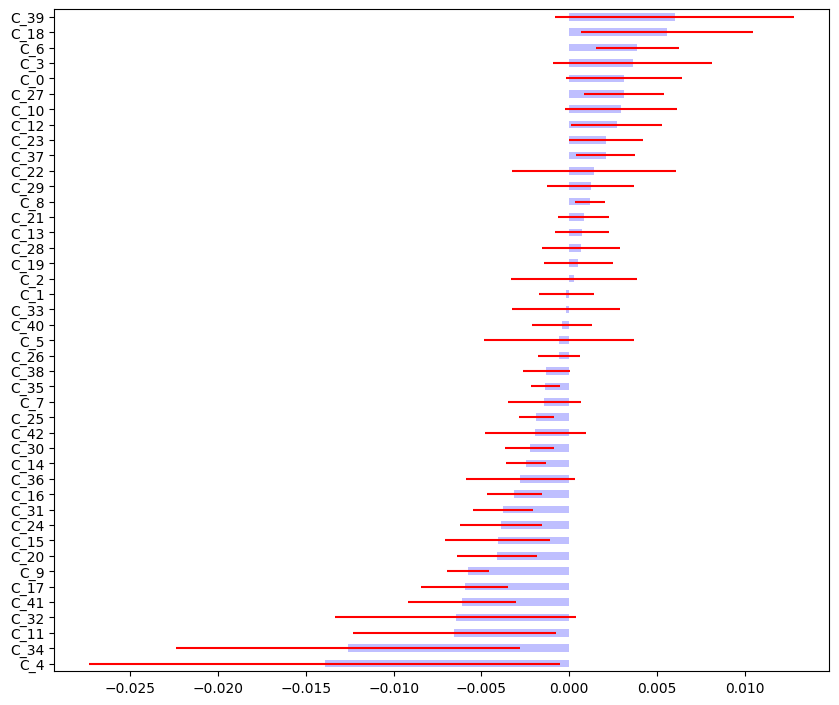

In [39]:
# cMDA importance with clf, sample weights

cpcv_gen = fml.cross_validation.CombinatorialPurgedKFold(n_splits=6, n_test_splits=2, samples_info_sets=triple_barrier_events.loc[X_train.index].t1, pct_embargo=0.01)

clf = DecisionTreeClassifier(
    criterion                = "entropy" , 
    max_features             = 1         , 
    class_weight             = "balanced", 
    min_weight_fraction_leaf = 0
    )
clf = BaggingClassifier(
    base_estimator = clf  , 
    n_estimators   = 1000 , 
    max_features   = 1.   ,
    max_samples    = 1.   , 
    oob_score      = False, 
    n_jobs         = -1
    )

importance = feature_importance_clustered_MDA(
    clf, X_train, y_train, clusters, 
    sample_weight=return_based_sample_weights_meta, 
    scoring="f1",   # f1 for harmonic average to detect opportunities, not going to trade aka not losing money is equally important as taking profitable trade, meaning money saved is money earned!
    cv_gen=cpcv_gen # Here I am trying not to overfit
    )

print(importance.head())

importance.sort_values('mean', inplace=True)
plt.figure(figsize=(10, importance.shape[0] / 5))
importance['mean'].plot(
    kind     = 'barh'           , 
    color    = 'b'              , 
    alpha    = 0.25             , 
    xerr     = importance['std'], 
    error_kw = {'ecolor': 'r'}
    )

In [40]:
# cMDA candidate features
import random

mda_clusters = [
    39,18,6,3,0,27,10,12,23,37
]
cluster_candidate_features = [random.choice(clusters[k]) for k in mda_clusters]
cluster_candidate_features = list(dict.fromkeys(cluster_candidate_features))
print("cMDA cluster candidate features for meta : ", cluster_candidate_features)

cMDA cluster candidate features for meta :  ['m_wr_50', 't_adx_50', 'vm_cmf_50', 'CORREL', 'HT_DCPHASE', 't_dpo_50', 't_macd_360_180', 'm_roc_120', 'vm_mfi_180', 'BBANDS_upperband']


In [41]:
parameters = {'max_depth':[2, 3, 4, 5, 7, 15, 20, 30, 40],
              'n_estimators':[10, 25, 50, 100, 256, 512]}

cv_gen_purged = fml.cross_validation.CombinatorialPurgedKFold(n_splits=6, n_test_splits=2, samples_info_sets=triple_barrier_events.loc[X_train.index].t1, pct_embargo=0.01)

def perform_grid_search_sample_weights(X_data, y_data, cv_gen, scoring, type='standard'):
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            print(f"depth={m_depth} estimators={n_est}")
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, 
                                        )
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            )
            temp_score_base = fml.cross_validation.ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring,
                                                                    sample_weight_train=return_based_sample_weights_meta.values)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score


top_model, cross_val_score = perform_grid_search_sample_weights(
    X_train[cluster_candidate_features], y_train, 
    cv_gen_purged, 
    f1_score     , # f1 for harmonic average, money saved is money earned!
    type='random_forest')

top_model

depth=2 estimators=10
0.7423222545293707
depth=2 estimators=25
depth=2 estimators=50
0.745070124128031
depth=2 estimators=100
0.7452390498070846
depth=2 estimators=256
0.7456202704669539
depth=2 estimators=512
0.7457498757015699
depth=3 estimators=10
depth=3 estimators=25
depth=3 estimators=50
depth=3 estimators=100
depth=3 estimators=256
depth=3 estimators=512
depth=4 estimators=10
depth=4 estimators=25
depth=4 estimators=50
depth=4 estimators=100
depth=4 estimators=256
depth=4 estimators=512
depth=5 estimators=10
depth=5 estimators=25
depth=5 estimators=50
depth=5 estimators=100
depth=5 estimators=256
depth=5 estimators=512
depth=7 estimators=10
depth=7 estimators=25
depth=7 estimators=50
depth=7 estimators=100
depth=7 estimators=256
depth=7 estimators=512
depth=15 estimators=10
depth=15 estimators=25
depth=15 estimators=50
depth=15 estimators=100
depth=15 estimators=256
depth=15 estimators=512
depth=20 estimators=10
depth=20 estimators=25
depth=20 estimators=50
depth=20 estimators=1

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=40, n_estimators=512, n_jobs=-1,
                       random_state=42)

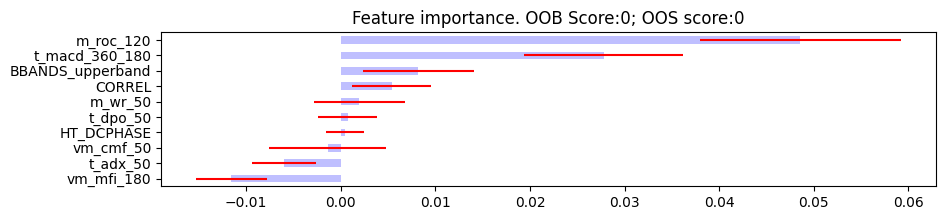

In [42]:
# about to sort candidate features for meta model
from mlfinlab.feature_importance import mean_decrease_accuracy, mean_decrease_impurity, single_feature_importance, plot_feature_importance

mda_feat_imp = mean_decrease_accuracy(top_model, X_train[cluster_candidate_features], y_train, cv_gen_purged, 
    scoring=f1_score, 
    sample_weight_train=return_based_sample_weights_meta.values)

plot_feature_importance(mda_feat_imp, 0, 0)

In [43]:
mda_feat_imp['mean_plus_std'] = mda_feat_imp['mean']+mda_feat_imp['std']
mda_feat_imp

,mean,std,mean_plus_std
vm_mfi_180,-0.011552,0.003703,-0.007849
t_adx_50,-0.006033,0.003401,-0.002632
vm_cmf_50,-0.001399,0.006162,0.004763
HT_DCPHASE,0.000474,0.002002,0.002476
t_dpo_50,0.000720,0.003105,0.003825
m_wr_50,0.001974,0.004766,0.006740
CORREL,0.005384,0.004170,0.009554
BBANDS_upperband,0.008215,0.005818,0.014033
t_macd_360_180,0.027773,0.008436,0.036209
m_roc_120,0.048594,0.010626,0.059219


In [44]:
importance_df = mda_feat_imp.copy()
importance_df.sort_values('mean_plus_std', ascending=True, inplace=True)

importance_df

,mean,std,mean_plus_std
vm_mfi_180,-0.011552,0.003703,-0.007849
t_adx_50,-0.006033,0.003401,-0.002632
HT_DCPHASE,0.000474,0.002002,0.002476
t_dpo_50,0.000720,0.003105,0.003825
vm_cmf_50,-0.001399,0.006162,0.004763
m_wr_50,0.001974,0.004766,0.006740
CORREL,0.005384,0.004170,0.009554
BBANDS_upperband,0.008215,0.005818,0.014033
t_macd_360_180,0.027773,0.008436,0.036209
m_roc_120,0.048594,0.010626,0.059219


<AxesSubplot: >

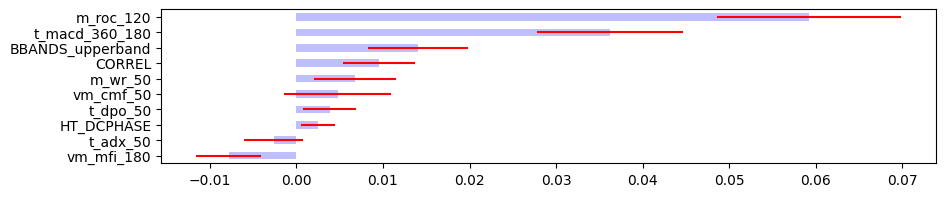

In [45]:
plt.figure(figsize=(10, importance_df.shape[0] / 5))
importance_df['mean_plus_std'].plot(
    kind     = 'barh'           , 
    color    = 'b'              , 
    alpha    = 0.25             , 
    xerr     = importance_df['std'], 
    error_kw = {'ecolor': 'r'}
    )

In [46]:
importance_threshold = 0.0
selected_cmda_features = list(importance_df[importance_df['mean']>importance_threshold].index)

print(selected_cmda_features)

['HT_DCPHASE', 't_dpo_50', 'm_wr_50', 'CORREL', 'BBANDS_upperband', 't_macd_360_180', 'm_roc_120']


In [47]:
selected_cmda_features = ['HT_DCPHASE', 't_dpo_50', 'm_wr_50', 'CORREL', 'BBANDS_upperband', 't_macd_360_180', 'm_roc_120']
selected_cmda_features

['HT_DCPHASE',
 't_dpo_50',
 'm_wr_50',
 'CORREL',
 'BBANDS_upperband',
 't_macd_360_180',
 'm_roc_120']

In [48]:
# parameter search for neg_log_loss

parameters = {'max_depth':[5, 10, 25, 30, 45, 50, 60, 70],
              'n_estimators':[10, 25, 50, 100, 256, 512]}

cv_gen_purged = fml.cross_validation.CombinatorialPurgedKFold(n_splits=8, n_test_splits=2, samples_info_sets=triple_barrier_events.loc[X_train.index].t1, pct_embargo=0.01)

def perform_grid_search_sample_weights(X_data, y_data, cv_gen, scoring, type='standard'):
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            print(f"depth={m_depth} estimators={n_est}")
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, 
                                        )
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            )
            temp_score_base = fml.cross_validation.ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring,
                                                                    sample_weight_train=return_based_sample_weights_meta.values)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score


top_model, cross_val_score = perform_grid_search_sample_weights(
    X_train[selected_cmda_features], y_train, 
    cv_gen_purged, 
    f1_score     ,
    type='random_forest')

top_model

depth=5 estimators=10
0.7240902952365357
depth=5 estimators=25
0.7264302834947266
depth=5 estimators=50
0.727810021667026
depth=5 estimators=100
0.7289233903643328
depth=5 estimators=256
0.7291832074426544
depth=5 estimators=512
0.7293972730969273
depth=10 estimators=10
depth=10 estimators=25
depth=10 estimators=50
depth=10 estimators=100
depth=10 estimators=256
0.7301066337389598
depth=10 estimators=512
0.7311374942717347
depth=25 estimators=10
depth=25 estimators=25
0.7381778410821689
depth=25 estimators=50
0.7440872544638238
depth=25 estimators=100
0.7507212592065075
depth=25 estimators=256
0.7545613737615052
depth=25 estimators=512
0.754927174436575
depth=30 estimators=10
depth=30 estimators=25
depth=30 estimators=50
depth=30 estimators=100
depth=30 estimators=256
depth=30 estimators=512
0.7558548579579343
depth=45 estimators=10
depth=45 estimators=25
depth=45 estimators=50
depth=45 estimators=100
depth=45 estimators=256
depth=45 estimators=512
0.7561323323184196
depth=50 estimator

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=45, n_estimators=512, n_jobs=-1,
                       random_state=42)

              precision    recall  f1-score   support

           0       0.62      0.03      0.05       297
           1       0.49      0.98      0.65       282

    accuracy                           0.49       579
   macro avg       0.55      0.50      0.35       579
weighted avg       0.55      0.49      0.34       579



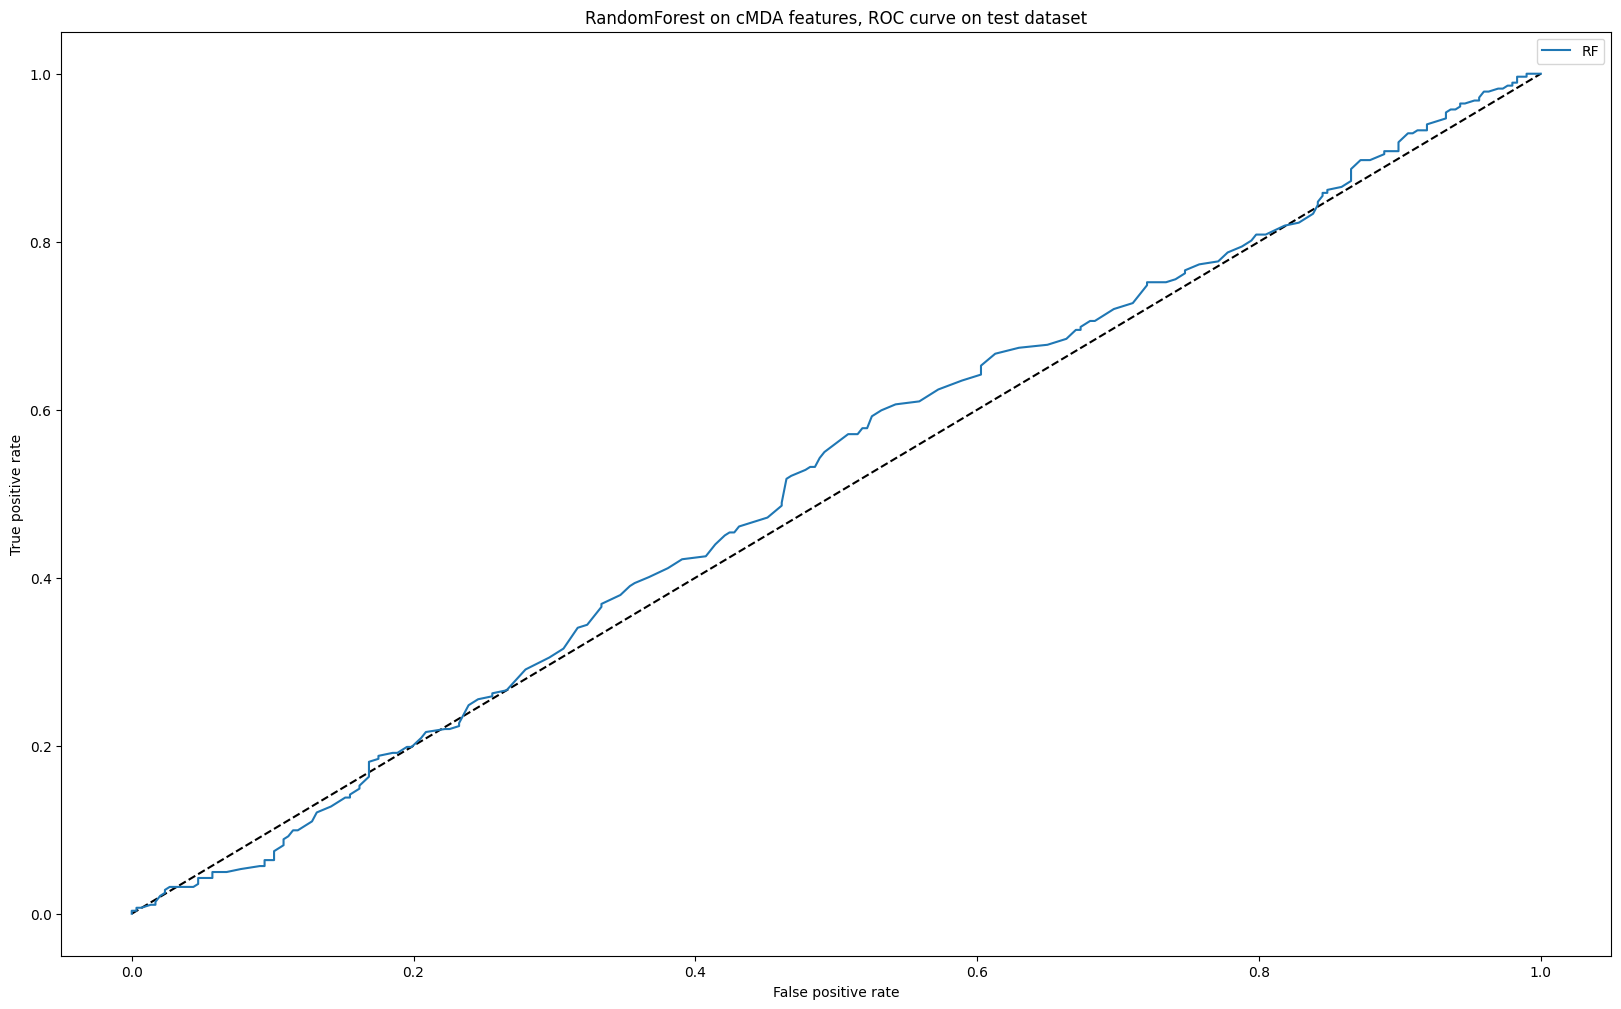

In [49]:
print(classification_report(
    y_test,
    top_model.predict(X_test[selected_cmda_features]),
    ))

fpr_rf, tpr_rf, _ = roc_curve(y_test, top_model.predict_proba(X_test[selected_cmda_features])[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RandomForest on cMDA features, ROC curve on test dataset')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.51      0.27      0.35       297
           1       0.49      0.73      0.58       282

    accuracy                           0.49       579
   macro avg       0.50      0.50      0.47       579
weighted avg       0.50      0.49      0.46       579



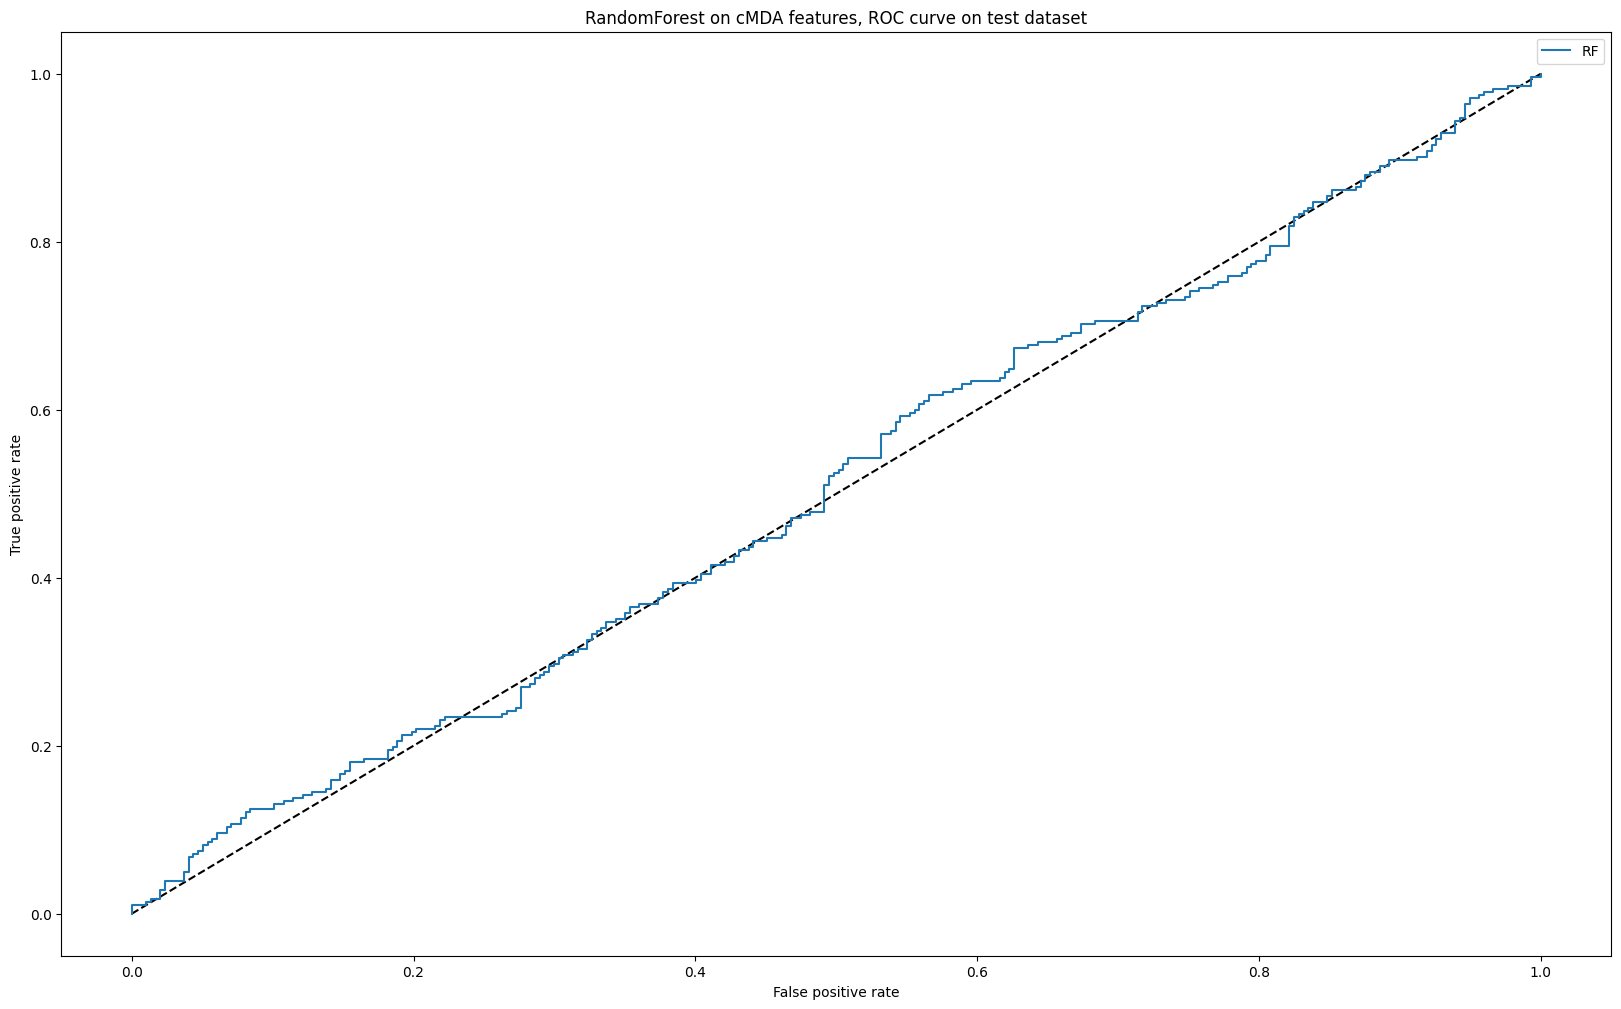

In [54]:
rf_meta = RandomForestClassifier(
    max_depth     = 15, 
    n_estimators  = 512,
    criterion     = 'entropy', 
    class_weight  = 'balanced_subsample',
    random_state  = 42,
    n_jobs        = -1
    )

rf_meta.fit(
    X_train[selected_cmda_features], 
    y_train,
    sample_weight=return_based_sample_weights_meta,
    )

print(classification_report(
    y_test,
    rf_meta.predict(X_test[selected_cmda_features]),
    ))

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_meta.predict_proba(X_test[selected_cmda_features])[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RandomForest on cMDA features, ROC curve on test dataset')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      4052
           1       0.92      0.99      0.95      7236

    accuracy                           0.94     11288
   macro avg       0.95      0.92      0.93     11288
weighted avg       0.94      0.94      0.94     11288



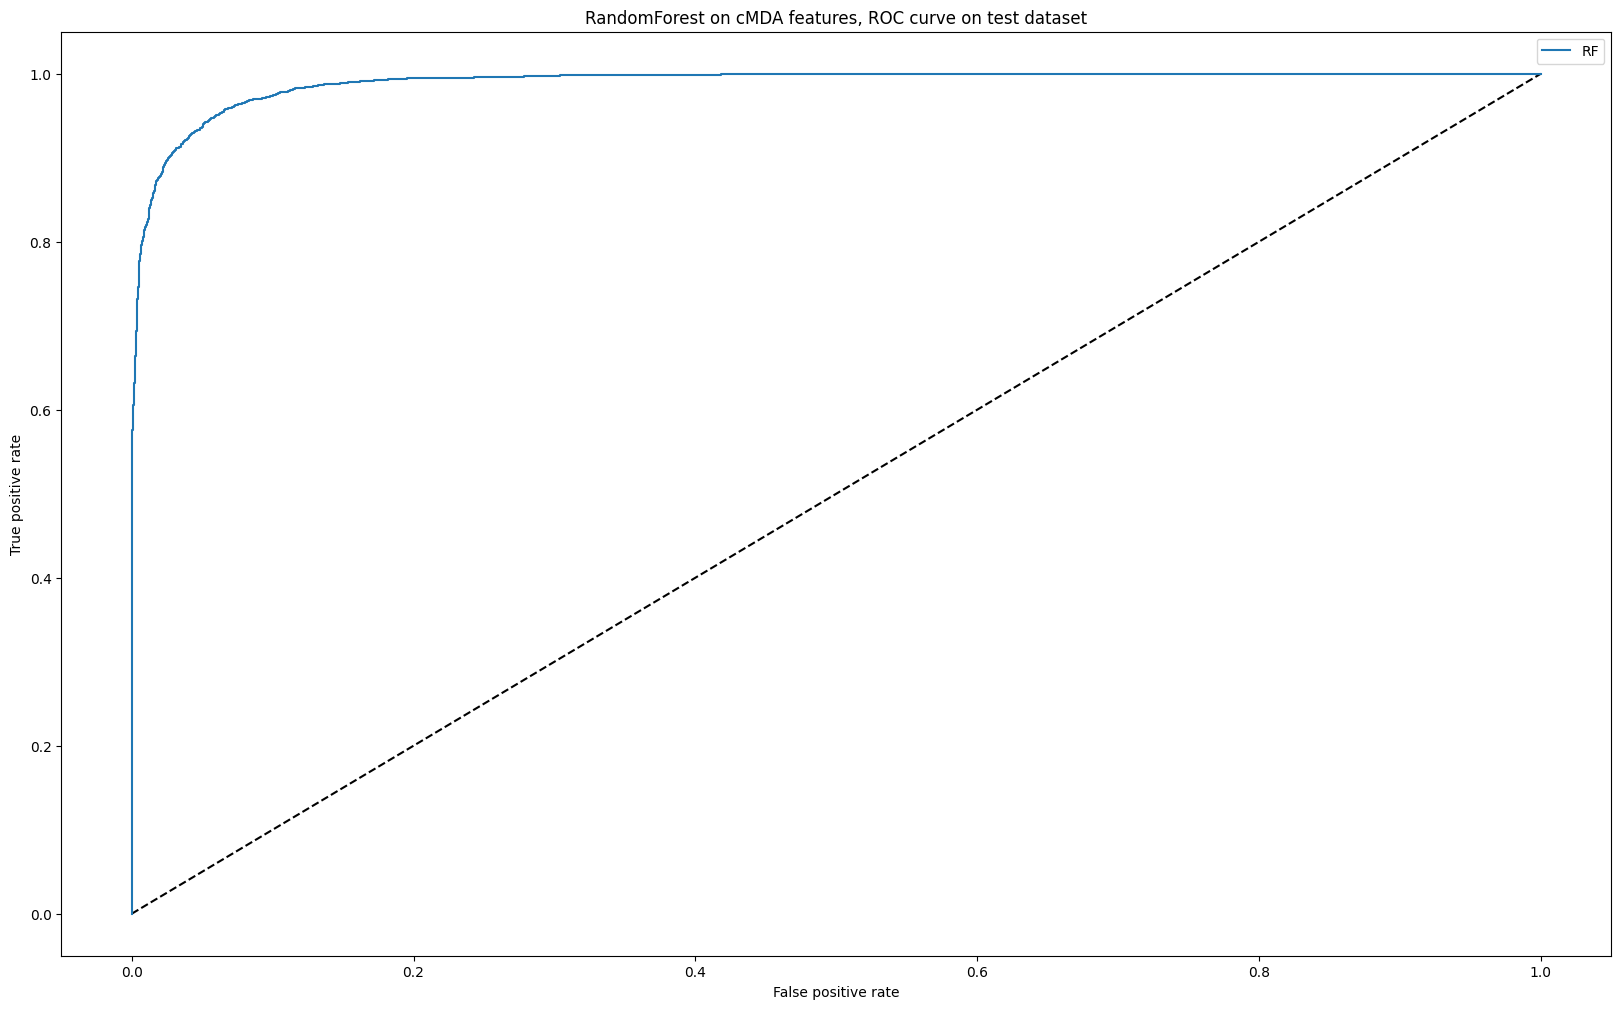

In [55]:
print(classification_report(
    y_train,
    rf_meta.predict(X_train[selected_cmda_features]),
    ))

fpr_rf, tpr_rf, _ = roc_curve(y_train, rf_meta.predict_proba(X_train[selected_cmda_features])[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RandomForest on cMDA features, ROC curve on test dataset')
plt.legend(loc='best')
plt.show()

In [56]:
selected_cmda_features

['HT_DCPHASE',
 't_dpo_50',
 'm_wr_50',
 'CORREL',
 'BBANDS_upperband',
 't_macd_360_180',
 'm_roc_120']

In [57]:
side_features

['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']

In [58]:
eval_features = selected_cmda_features+side_features+['Open', 'High', 'Low', 'Close', 'Volume', 'volatility_tpsl']
eval_features = list(dict.fromkeys(eval_features))
eval_features

['HT_DCPHASE',
 't_dpo_50',
 'm_wr_50',
 'CORREL',
 'BBANDS_upperband',
 't_macd_360_180',
 'm_roc_120',
 'ma_440',
 'daily_volatility_30',
 'vm_eom_25',
 'vl_atr_180',
 'vm_cmf_180',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'volatility_tpsl']

In [59]:
eval_df = df["2022-01-24":][eval_features].copy()
eval_df

,HT_DCPHASE,t_dpo_50,m_wr_50,CORREL,BBANDS_upperband,t_macd_360_180,m_roc_120,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180,Open,High,Low,Close,Volume,volatility_tpsl
timestamp,,,,,,,,,,,,,,,,,,
2022-01-24 00:00:00,243.759045,-98.4094,-45.359649,0.756686,73.413993,7.320733,2.421400,0.024072,0.004066,-4.259002e+09,63.218028,0.141326,36244.55,36251.50,36176.45,36192.65,63.73696,0.016407
2022-01-24 00:01:00,260.672682,-97.2856,-81.732312,0.765470,118.787384,6.730951,2.271898,0.022592,0.004148,-5.391770e+09,63.247761,0.135099,36192.64,36206.21,36137.64,36142.50,53.47722,0.016415
2022-01-24 00:02:00,278.037898,-105.5852,-97.614839,0.816158,152.418798,6.126634,2.137832,0.021839,0.004168,-2.188362e+09,63.219773,0.127484,36138.18,36169.61,36111.40,36117.98,83.57659,0.016423
2022-01-24 00:03:00,295.167961,-79.5524,-93.085338,0.828021,123.061234,5.698836,2.242764,0.022279,0.004058,-3.444035e+08,63.129552,0.124672,36117.98,36159.43,36112.45,36135.66,62.27106,0.016442
2022-01-24 00:04:00,310.313457,-78.3314,-92.588352,0.841948,70.326216,5.295099,2.221357,0.021973,0.003991,-6.202526e+08,63.087666,0.124010,36135.66,36152.79,36097.20,36126.98,98.09432,0.016454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 23:55:00,137.443497,-13.9494,-12.317812,0.906359,5.685241,1.639263,0.963493,0.002529,0.001137,2.841518e+06,21.196827,0.016900,23149.08,23159.53,23145.27,23149.98,132.98878,0.013229
2023-01-31 23:56:00,152.595072,0.2534,-32.838901,0.895144,19.122611,1.578830,0.878575,0.001843,0.001173,-1.739679e+08,21.217012,0.016897,23150.82,23151.77,23126.94,23134.07,186.18800,0.013213
2023-01-31 23:57:00,177.568721,-1.0010,-24.764607,0.900788,19.450840,1.553527,0.852220,0.002120,0.001170,-2.711517e+07,21.180139,0.020413,23133.44,23144.59,23130.01,23140.33,110.49868,0.013199


In [60]:
eval_df['position'  ] = side_rf.predict(eval_df[side_features])
eval_df['short_prob'] = side_rf.predict_proba(eval_df[side_features])[:,0]
eval_df['long_prob' ] = side_rf.predict_proba(eval_df[side_features])[:,1]

In [61]:
eval_df['position'].value_counts()

 1.0    292832
-1.0    244288
Name: position, dtype: int64

<AxesSubplot: >

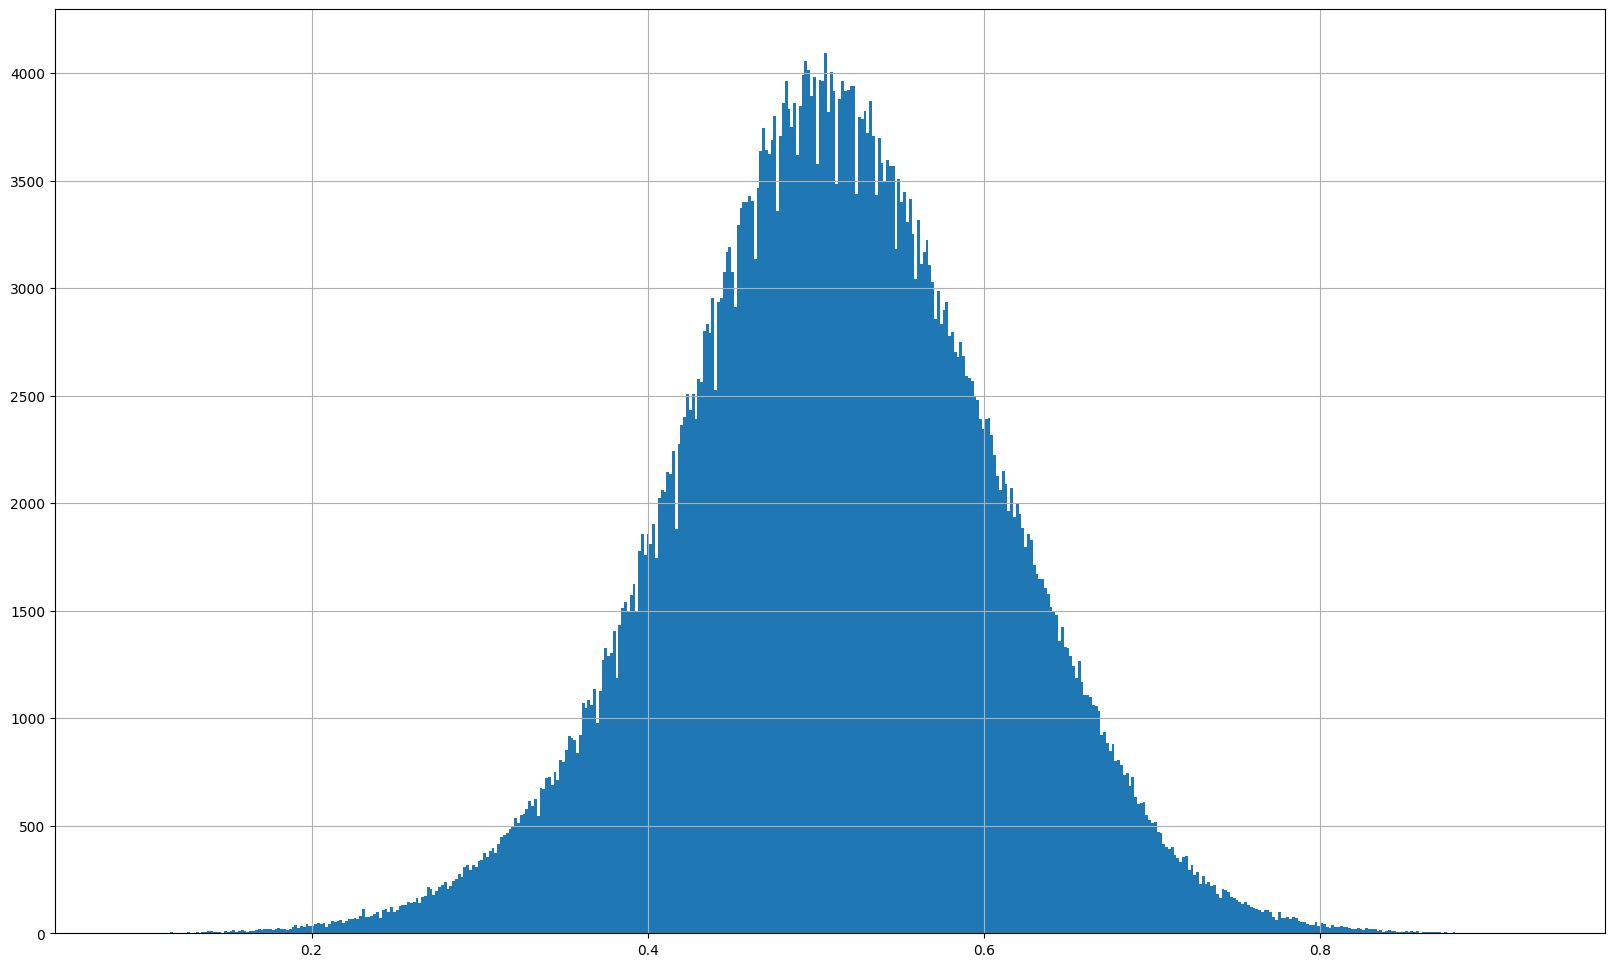

In [62]:
eval_df['long_prob'].hist(bins=500)

<AxesSubplot: >

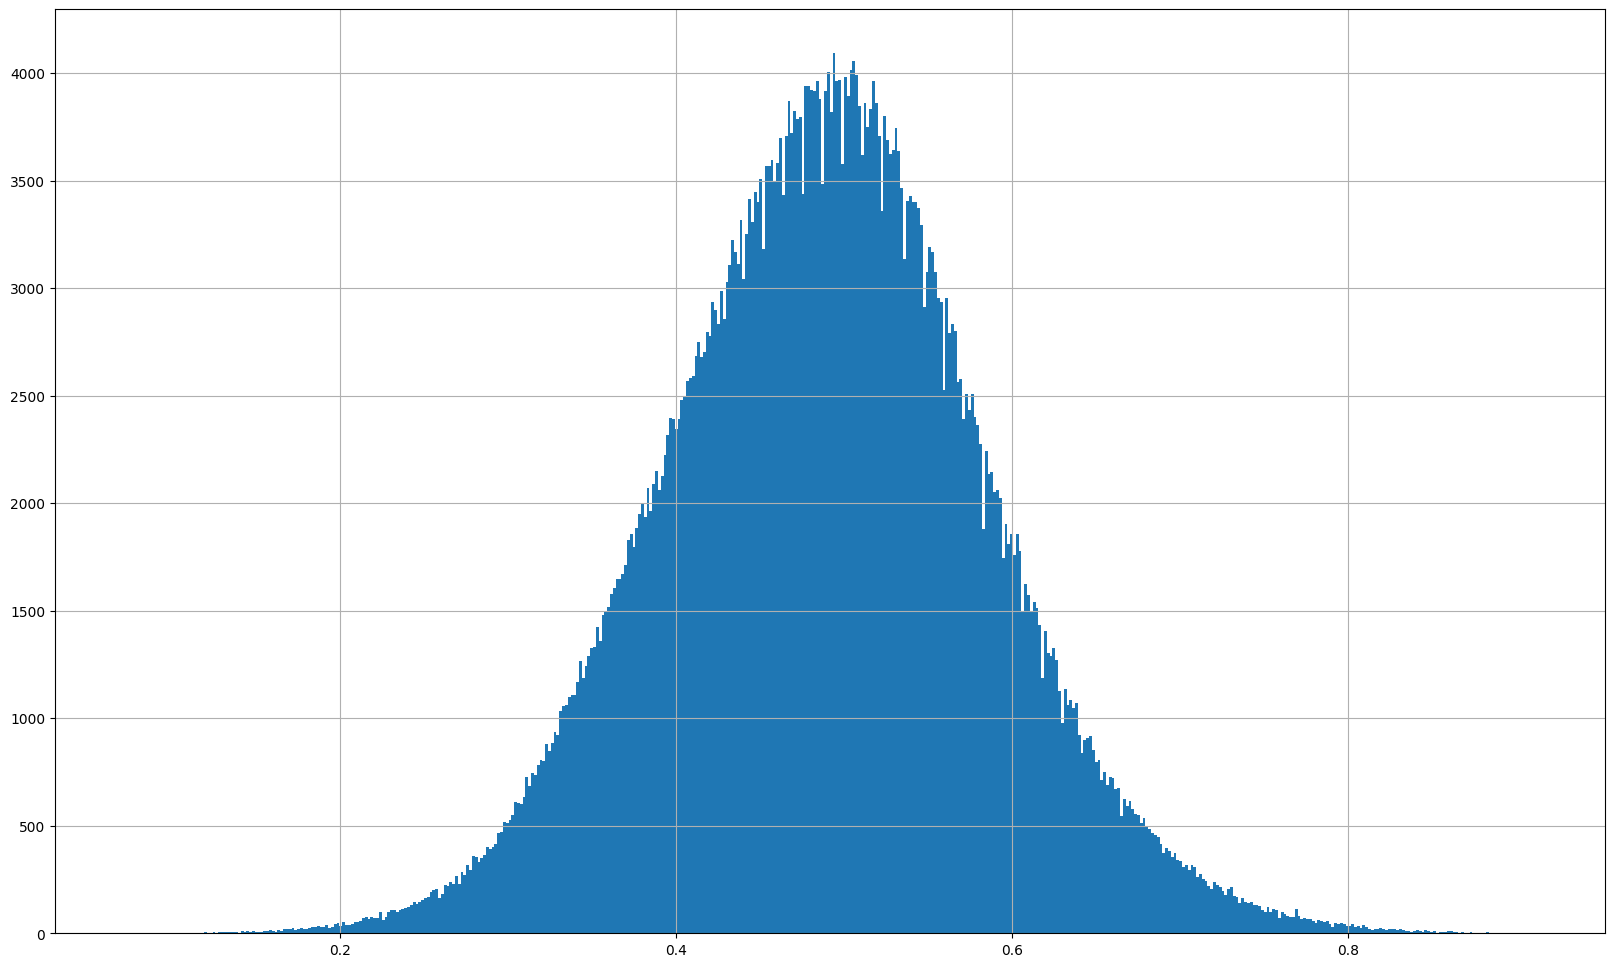

In [63]:
eval_df['short_prob'].hist(bins=500)

In [64]:
primary_threshold = 0.65

eval_df['is_signal'] = False
eval_df.loc[(eval_df['short_prob']>=primary_threshold)|(eval_df['long_prob']>=primary_threshold), 'is_signal'] = True

In [70]:
eval_df[eval_df['is_signal']==True]['position'].value_counts()

 1.0    39290
-1.0    25489
Name: position, dtype: int64

In [71]:
signal_indexes = eval_df[eval_df['is_signal']==True].index
eval_df['act'] = 0
eval_df.loc[signal_indexes, 'act'     ] = top_model.predict(eval_df.loc[signal_indexes][selected_cmda_features])
eval_df.loc[signal_indexes, 'act_prob'] = top_model.predict_proba(eval_df.loc[signal_indexes][selected_cmda_features])[:,1]

In [72]:
eval_df['act'].value_counts()

0    474961
1     62159
Name: act, dtype: int64

<AxesSubplot: >

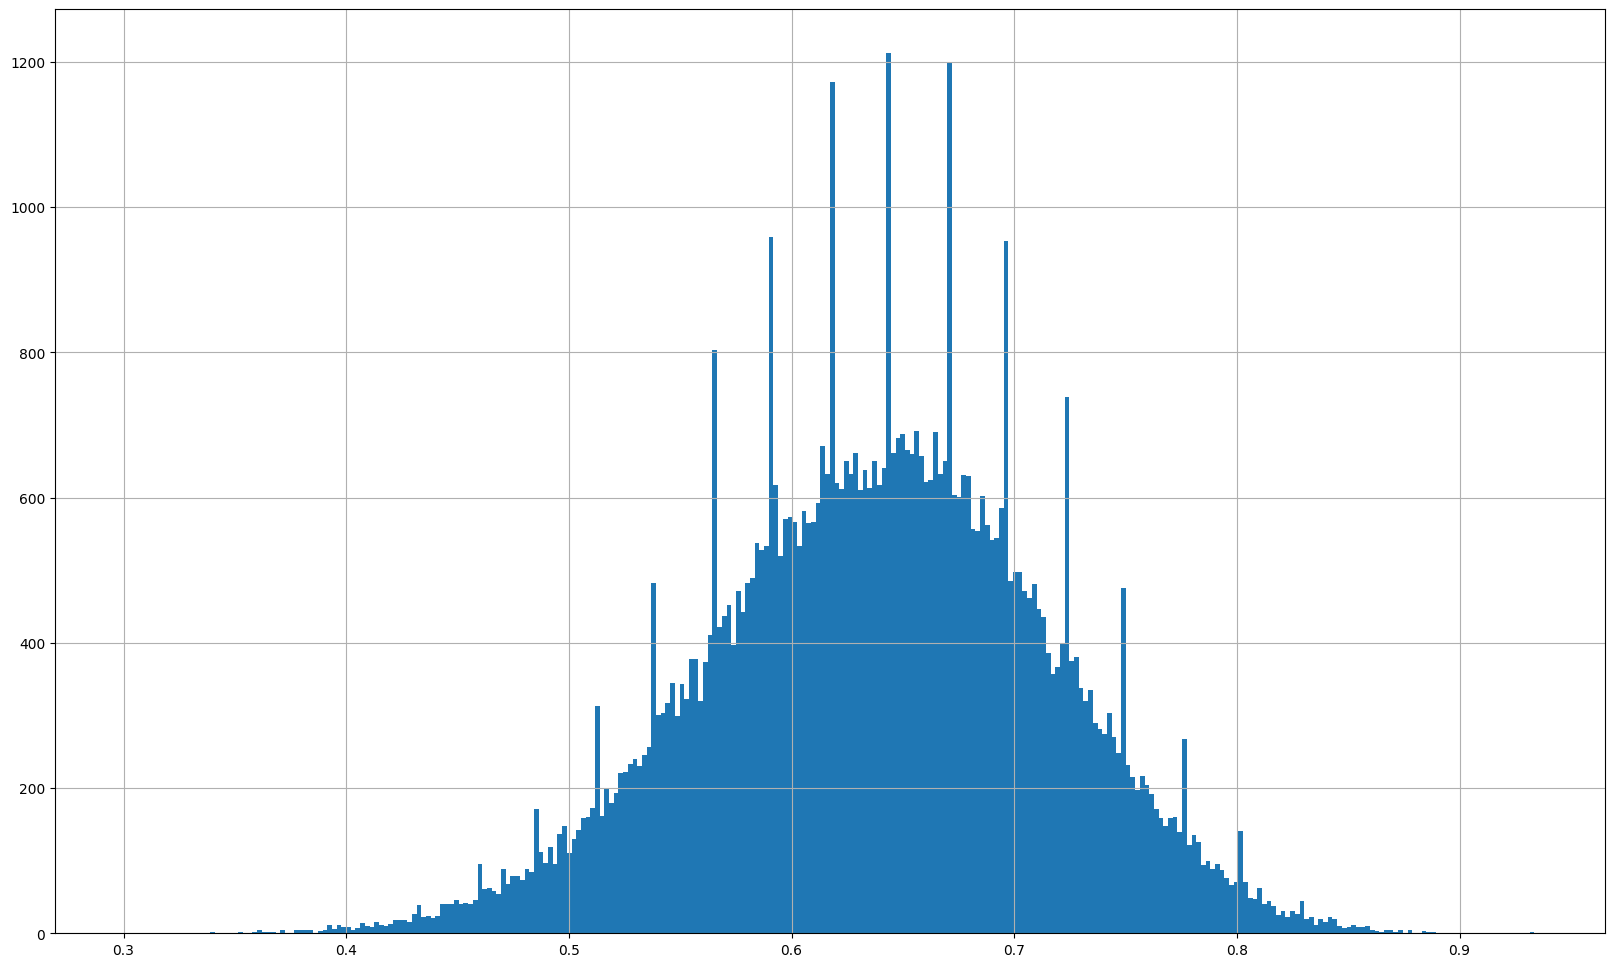

In [73]:
eval_df['act_prob'].hist(bins=300)

In [74]:
# Model performance evaluation on OOS data

from backtesting     import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()

def kelly(prob_win, payout_perc):
    return (prob_win * payout_perc - (1 - prob_win)) / payout_perc

binance_commission = 0.0004  # Taker Fee rate is 0.04%

In [75]:
act_threshold = 0.51

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1

        if position==1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-24 00:00:00
End                       2023-01-31 23:59:00
Duration                    372 days 23:59:00
Exposure Time [%]                   93.936364
Equity Final [$]             104025197.804405
Equity Peak [$]              107208644.861668
Return [%]                           4.025198
Buy & Hold Return [%]              -36.105452
Return (Ann.) [%]                    3.817978
Volatility (Ann.) [%]                5.917889
Sharpe Ratio                         0.645159
Sortino Ratio                        1.006343
Calmar Ratio                         0.707034
Max. Drawdown [%]                   -5.399994
Avg. Drawdown [%]                   -0.109067
Max. Drawdown Duration      227 days 03:07:00
Avg. Drawdown Duration        1 days 02:05:00
# Trades                                 2016
Win Rate [%]                        52.132937
Best Trade [%]                       5.160685
Worst Trade [%]                     -6.339686
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-01-31
Total months,96
,Backtest
Annual return,3.1%
Cumulative returns,27.8%
Annual volatility,20.4%
Sharpe ratio,0.25
Calmar ratio,0.07
Stability,0.00
Max drawdown,-44.6%


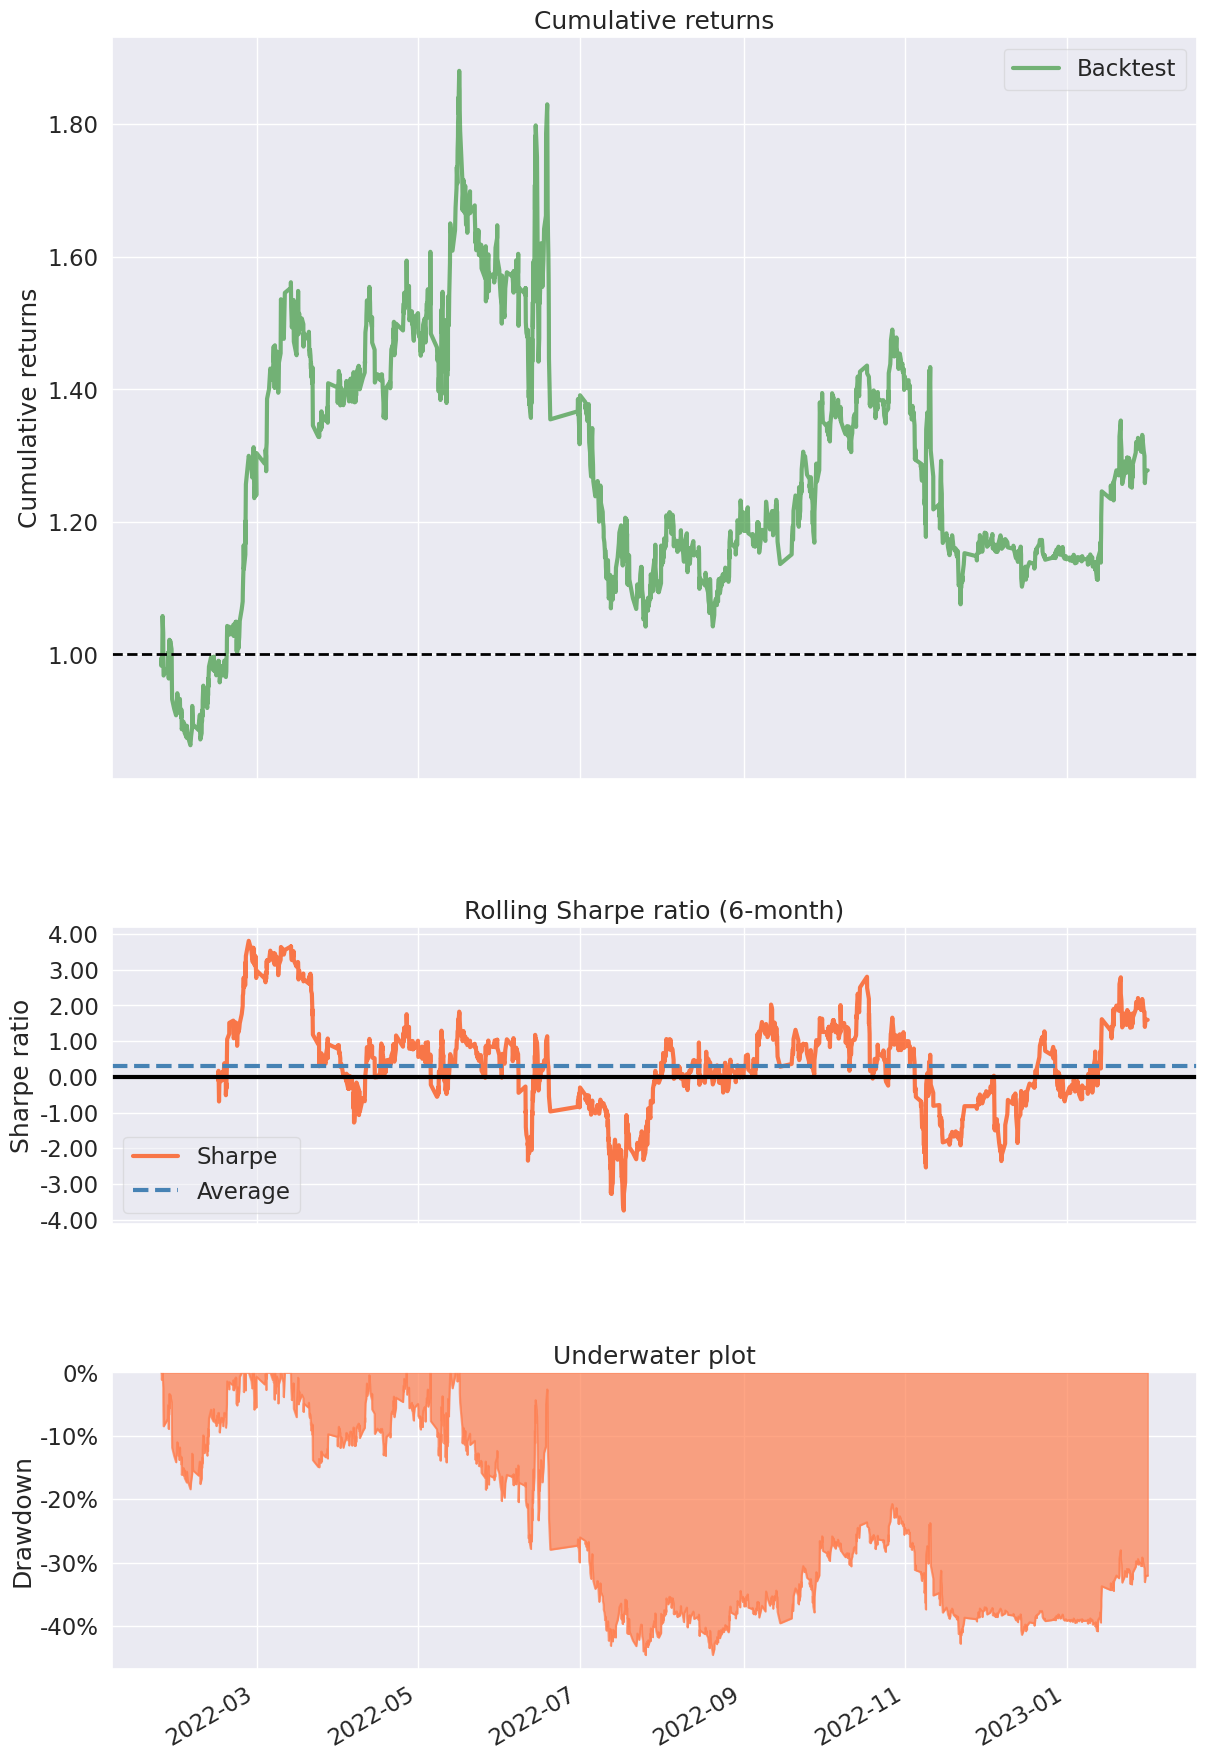

In [76]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [77]:
act_threshold = 0.58

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1

        if position==1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-24 00:00:00
End                       2023-01-31 23:59:00
Duration                    372 days 23:59:00
Exposure Time [%]                   92.882782
Equity Final [$]             108072938.547206
Equity Peak [$]              108739758.783291
Return [%]                           8.072939
Buy & Hold Return [%]              -36.105452
Return (Ann.) [%]                    7.534587
Volatility (Ann.) [%]                 6.31282
Sharpe Ratio                         1.193537
Sortino Ratio                         2.16391
Calmar Ratio                         1.598975
Max. Drawdown [%]                   -4.712137
Avg. Drawdown [%]                   -0.103387
Max. Drawdown Duration      227 days 03:07:00
Avg. Drawdown Duration        1 days 03:32:00
# Trades                                 2001
Win Rate [%]                        52.223888
Best Trade [%]                       5.613628
Worst Trade [%]                     -6.339686
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-01-31
Total months,95
,Backtest
Annual return,8.2%
Cumulative returns,87.4%
Annual volatility,20.5%
Sharpe ratio,0.49
Calmar ratio,0.21
Stability,0.60
Max drawdown,-39.2%


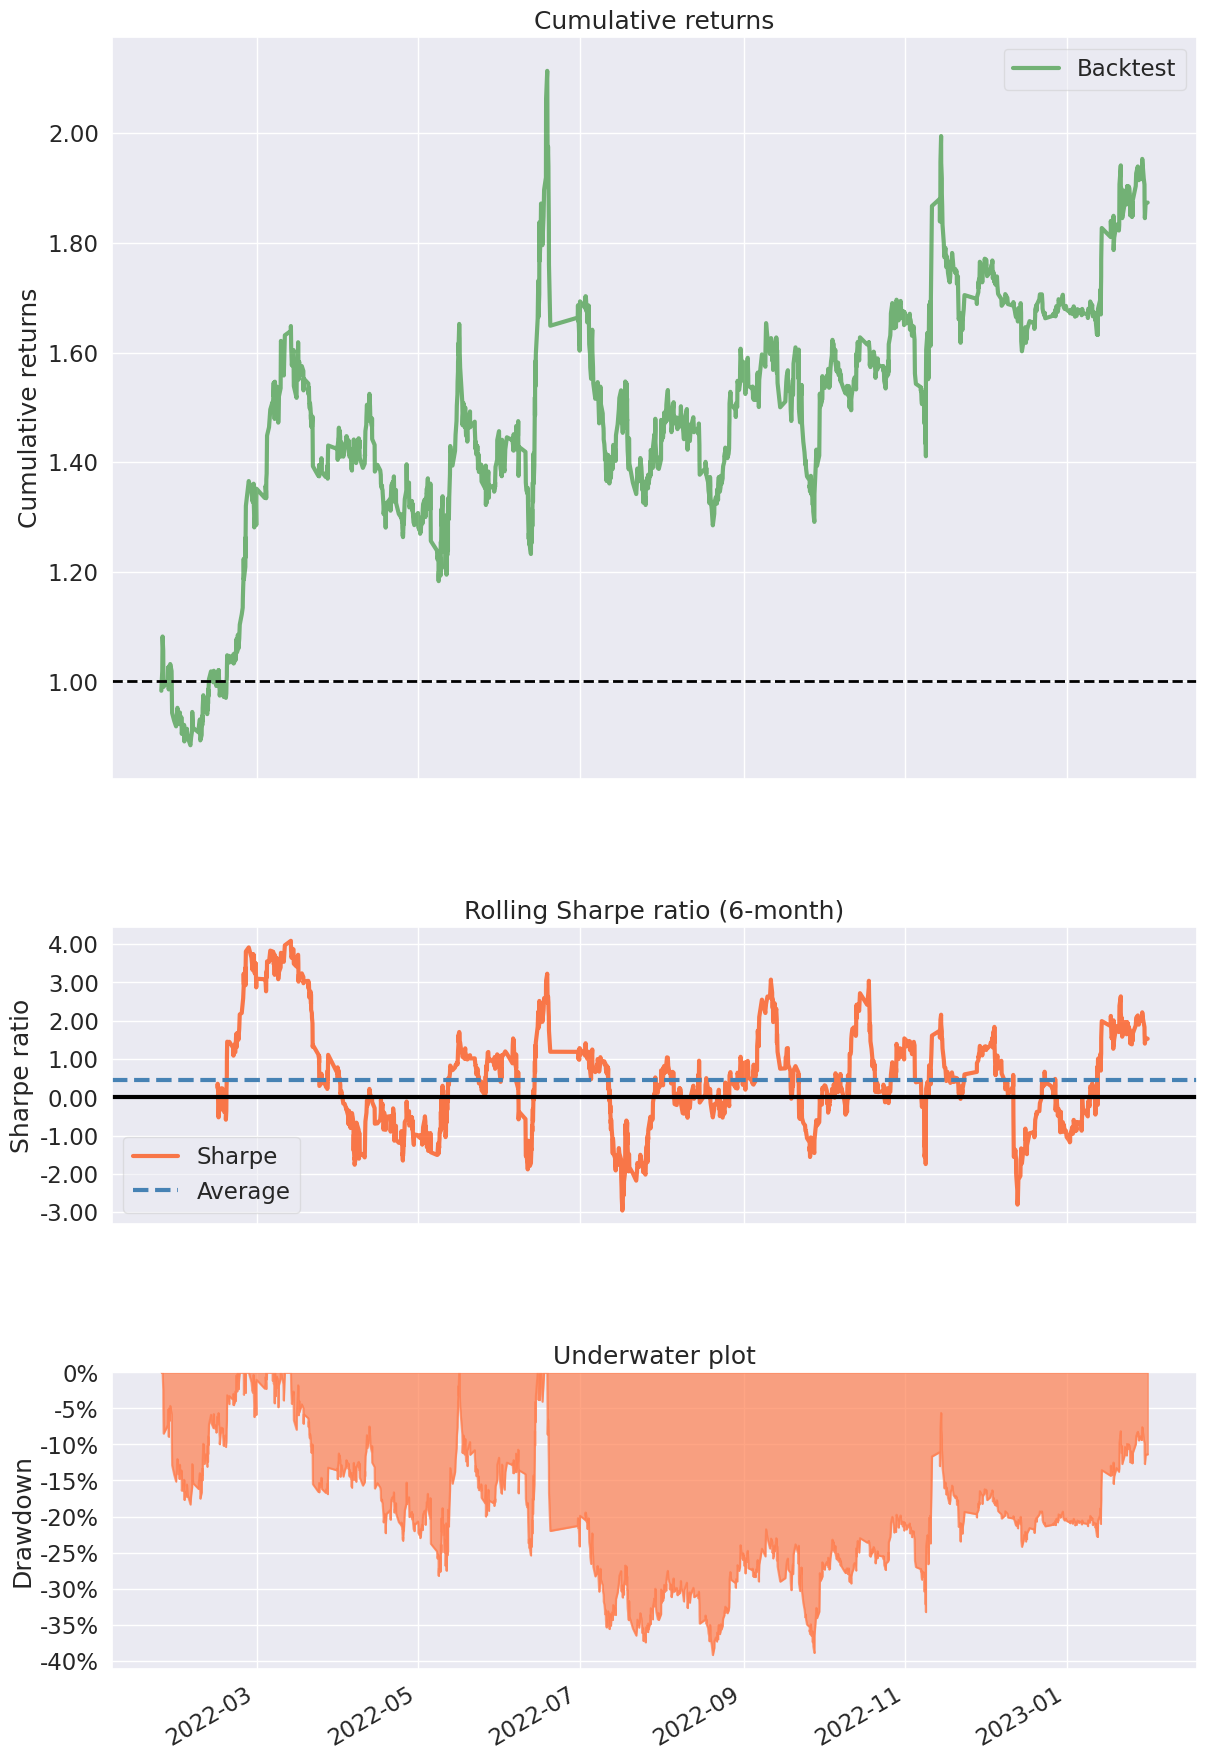

In [78]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [79]:
act_threshold = 0.65

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1

        if position==1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-24 00:00:00
End                       2023-01-31 23:59:00
Duration                    372 days 23:59:00
Exposure Time [%]                   89.473488
Equity Final [$]             104332053.069029
Equity Peak [$]              105722555.988235
Return [%]                           4.332053
Buy & Hold Return [%]              -36.105452
Return (Ann.) [%]                    4.186414
Volatility (Ann.) [%]                5.761068
Sharpe Ratio                         0.726673
Sortino Ratio                        1.161342
Calmar Ratio                         0.811302
Max. Drawdown [%]                   -5.160116
Avg. Drawdown [%]                   -0.129799
Max. Drawdown Duration      227 days 03:07:00
Avg. Drawdown Duration        1 days 12:40:00
# Trades                                 1742
Win Rate [%]                        51.664753
Best Trade [%]                       5.300927
Worst Trade [%]                     -6.305794
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-01-31
Total months,82
,Backtest
Annual return,4.2%
Cumulative returns,32.6%
Annual volatility,21.5%
Sharpe ratio,0.30
Calmar ratio,0.10
Stability,0.00
Max drawdown,-42.0%


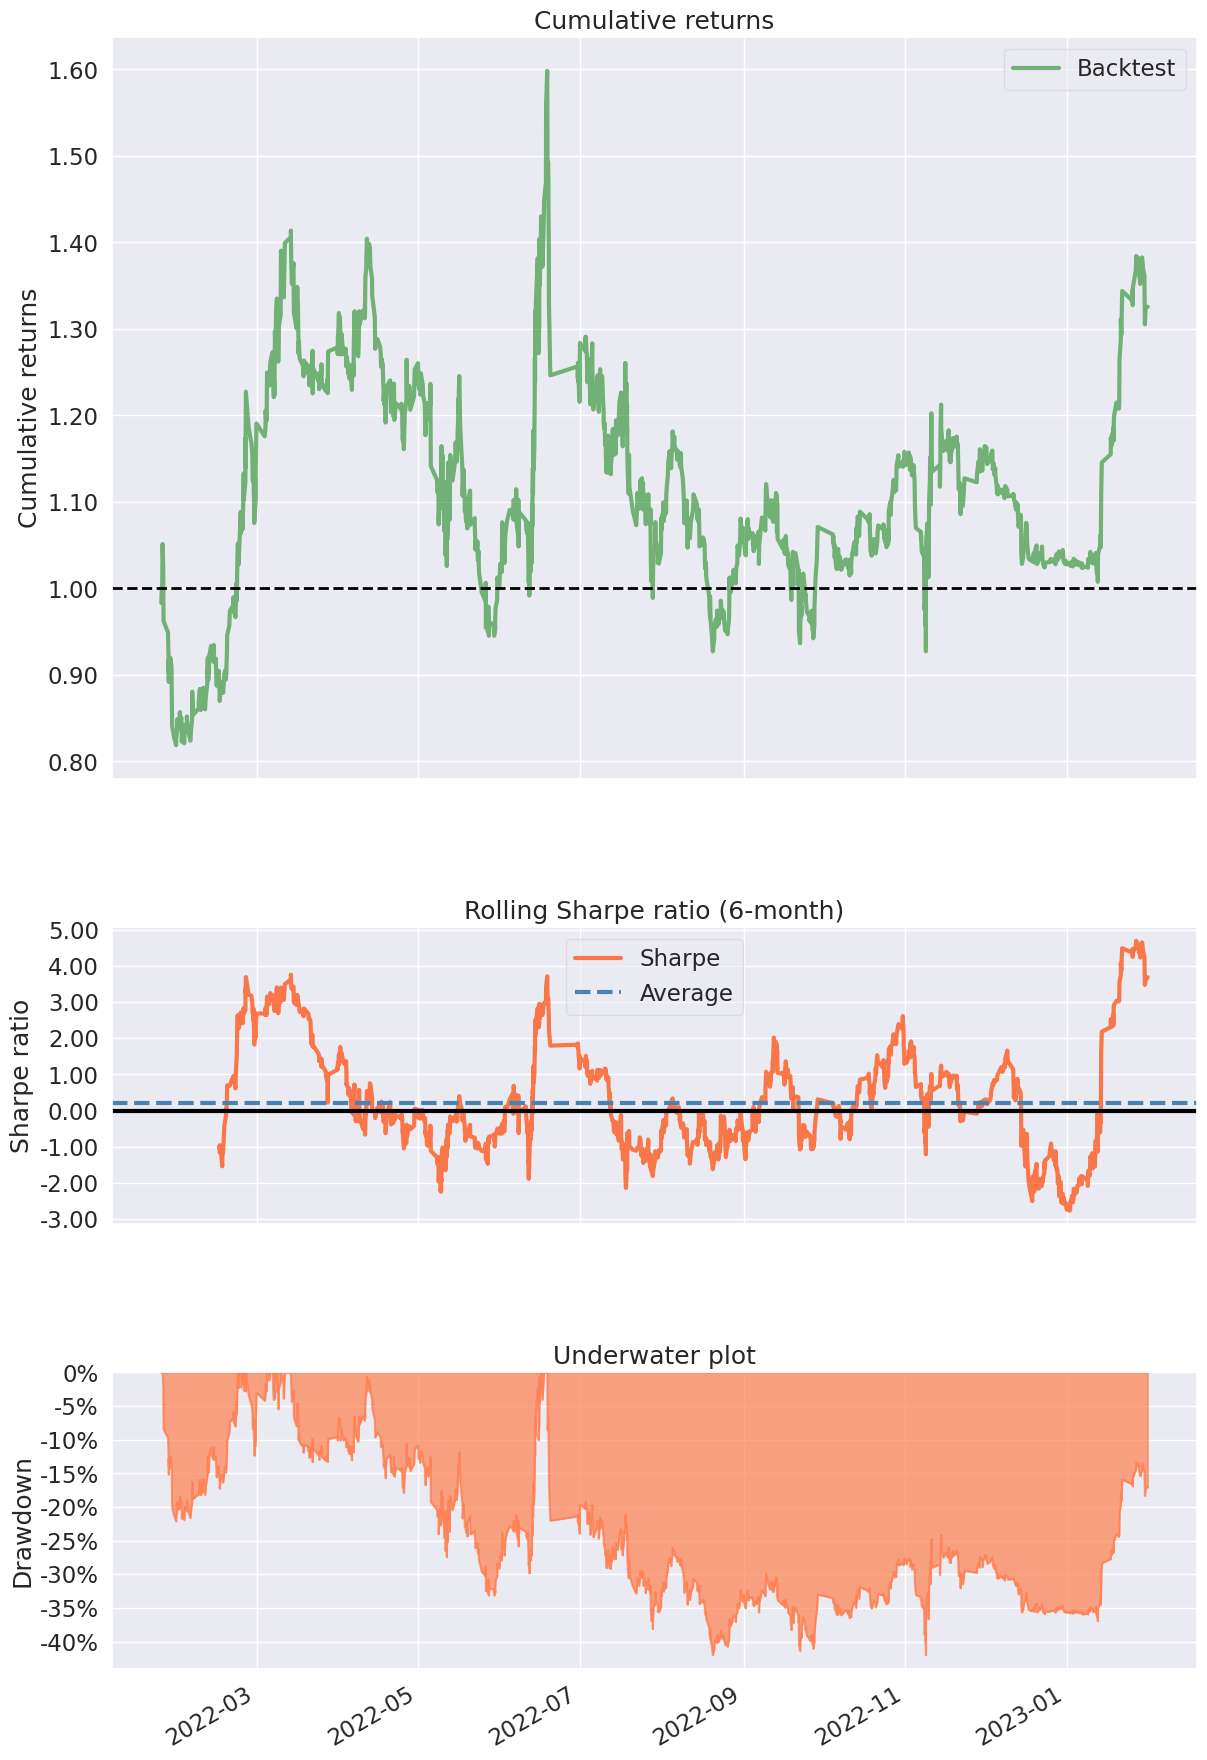

In [80]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [81]:
signal_indexes = eval_df[eval_df['is_signal']==True].index
eval_df['act'] = 0
eval_df.loc[signal_indexes, 'act'     ] = rf_meta.predict(eval_df.loc[signal_indexes][selected_cmda_features])
eval_df.loc[signal_indexes, 'act_prob'] = rf_meta.predict_proba(eval_df.loc[signal_indexes][selected_cmda_features])[:,1]

In [82]:
eval_df['act'].value_counts()

0    485850
1     51270
Name: act, dtype: int64

<AxesSubplot: >

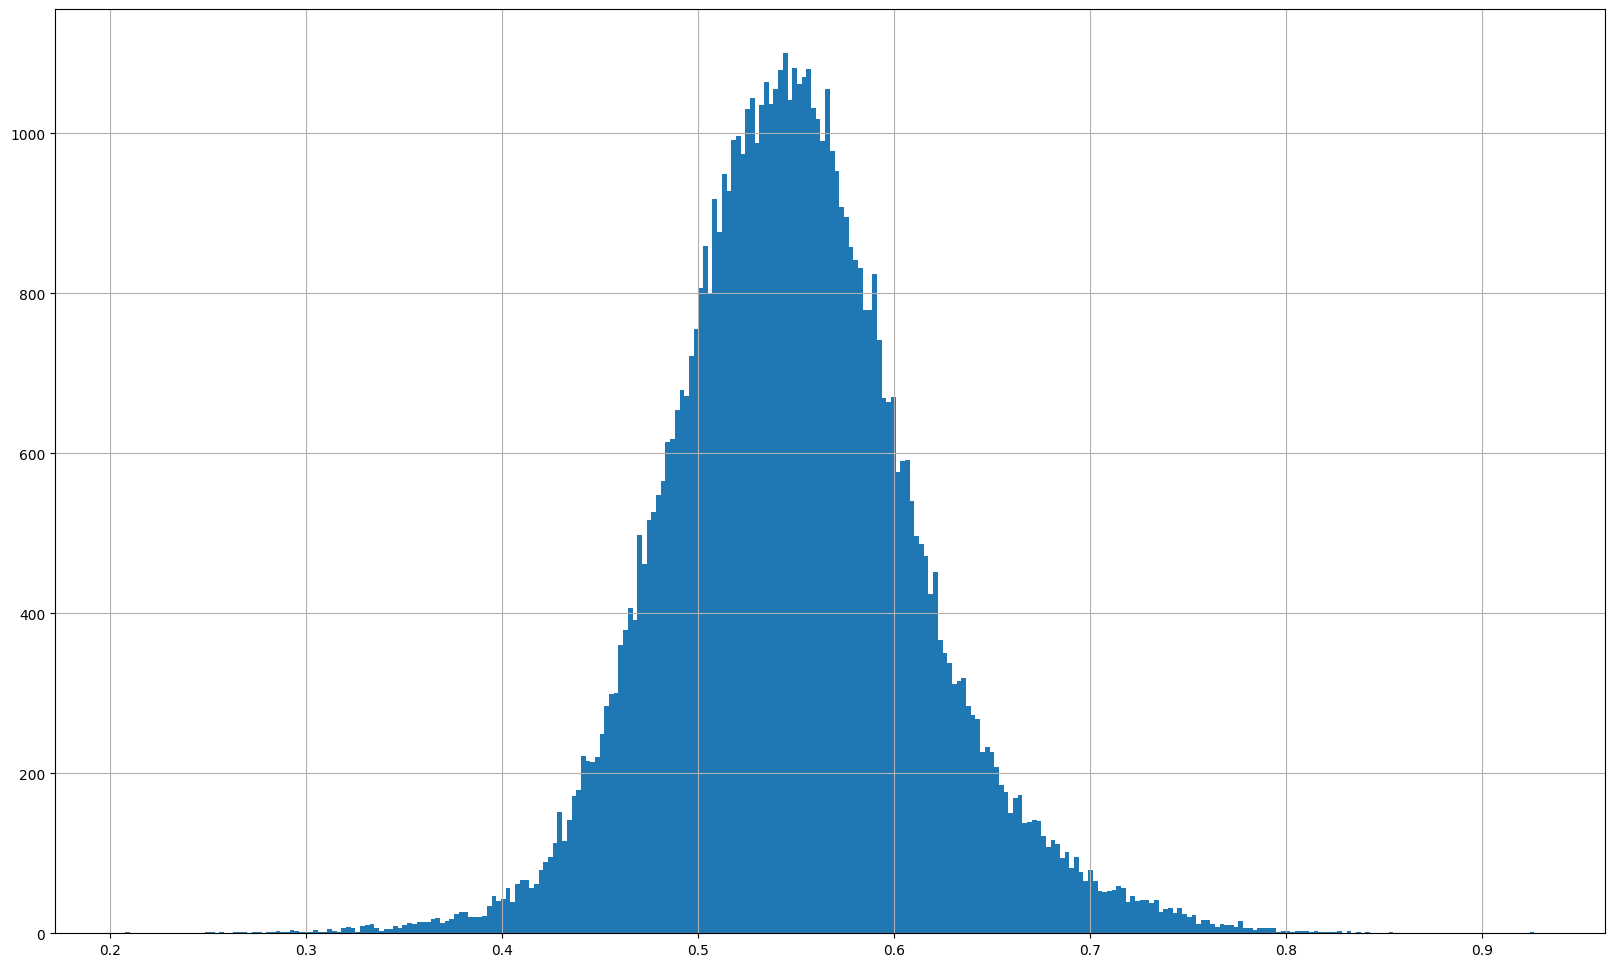

In [83]:
eval_df['act_prob'].hist(bins=300)

In [84]:
act_threshold = 0.55

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1

        if position==1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-24 00:00:00
End                       2023-01-31 23:59:00
Duration                    372 days 23:59:00
Exposure Time [%]                    89.69113
Equity Final [$]             107297344.035597
Equity Peak [$]              107731654.778058
Return [%]                           7.297344
Buy & Hold Return [%]              -36.105452
Return (Ann.) [%]                    6.380939
Volatility (Ann.) [%]                6.377563
Sharpe Ratio                         1.000529
Sortino Ratio                        1.675256
Calmar Ratio                          1.22245
Max. Drawdown [%]                   -5.219796
Avg. Drawdown [%]                   -0.097674
Max. Drawdown Duration      148 days 10:43:00
Avg. Drawdown Duration        1 days 02:06:00
# Trades                                 1801
Win Rate [%]                        52.970572
Best Trade [%]                       5.613628
Worst Trade [%]                     -6.339686
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-01-31
Total months,85
,Backtest
Annual return,8.2%
Cumulative returns,75.8%
Annual volatility,21.0%
Sharpe ratio,0.48
Calmar ratio,0.19
Stability,0.53
Max drawdown,-42.4%


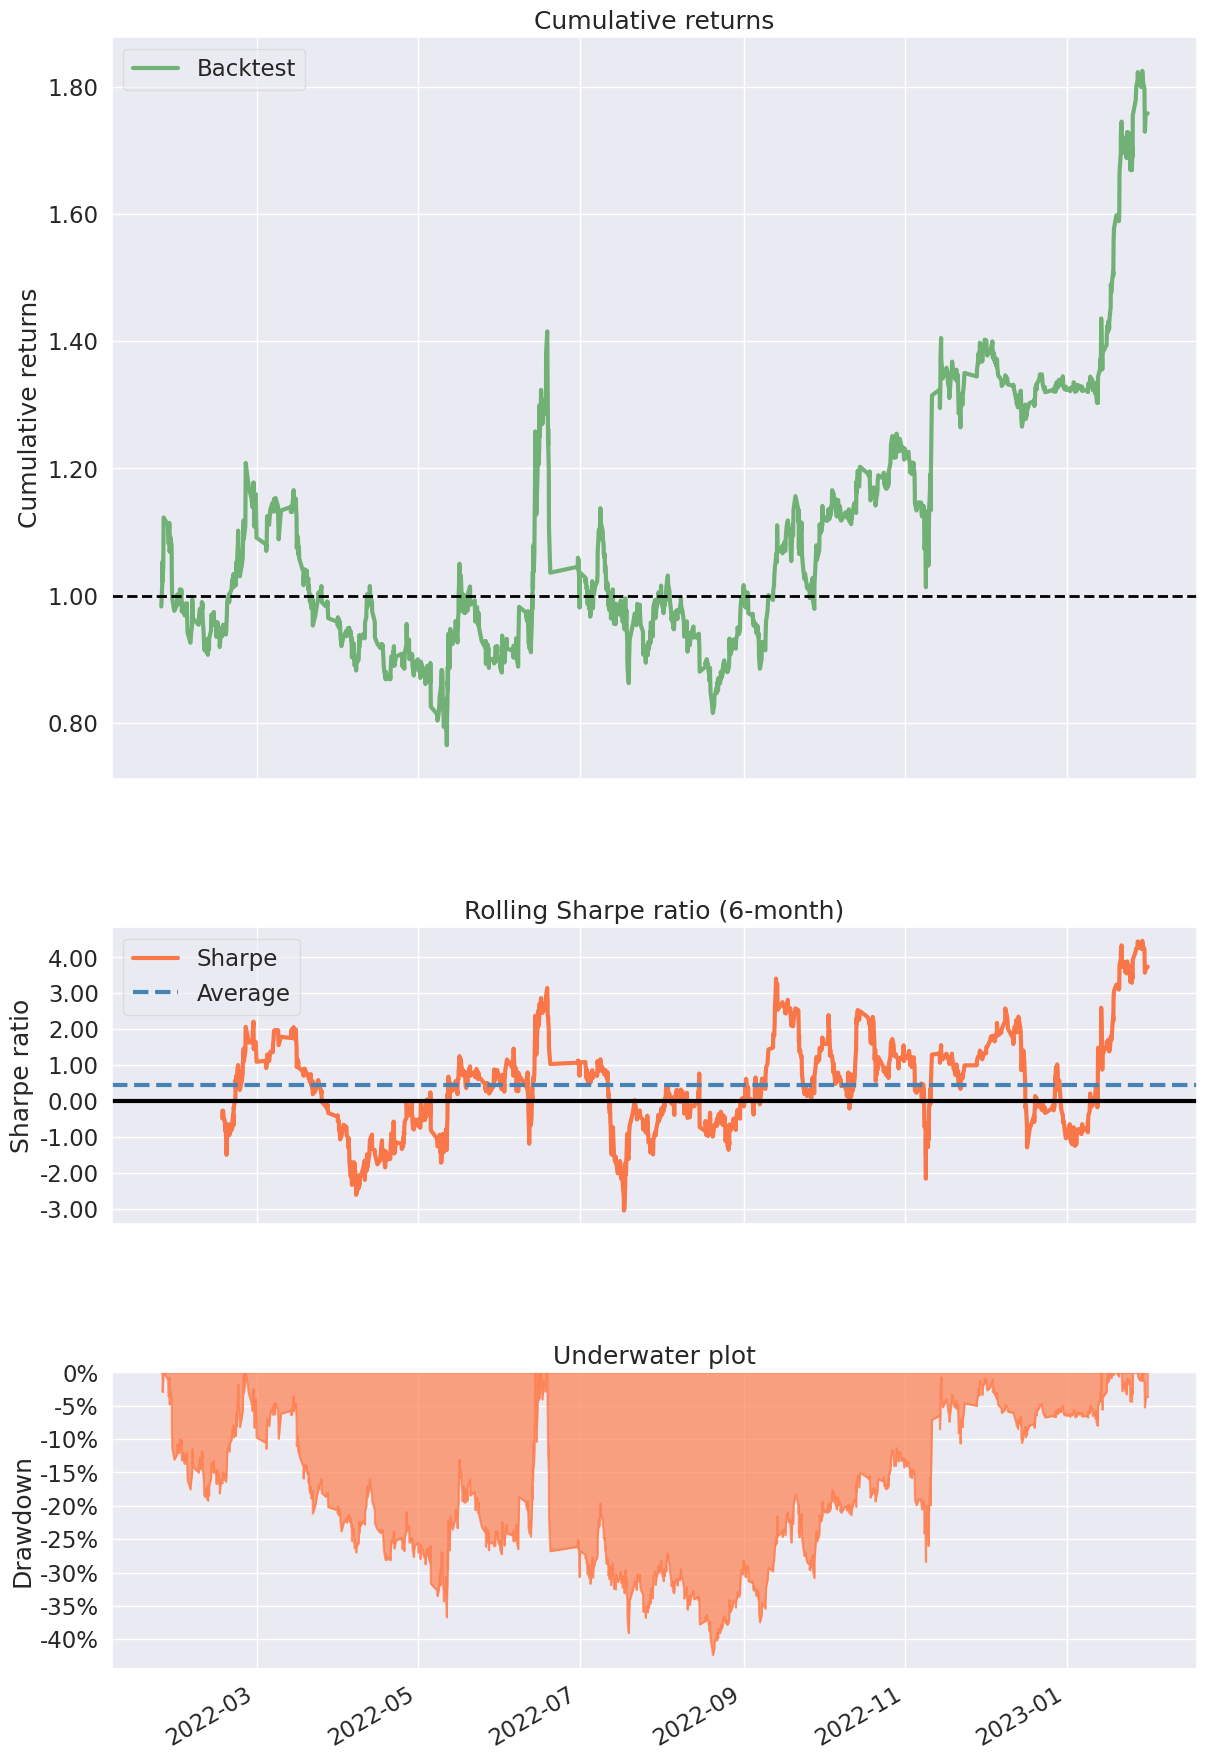

In [85]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [86]:
act_threshold = 0.65

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1

        if position==1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-24 00:00:00
End                       2023-01-31 23:59:00
Duration                    372 days 23:59:00
Exposure Time [%]                   62.528671
Equity Final [$]             104206270.061636
Equity Peak [$]              104838309.197444
Return [%]                            4.20627
Buy & Hold Return [%]              -36.105452
Return (Ann.) [%]                    4.227835
Volatility (Ann.) [%]                4.511741
Sharpe Ratio                         0.937074
Sortino Ratio                        1.453351
Calmar Ratio                         1.509049
Max. Drawdown [%]                   -2.801656
Avg. Drawdown [%]                    -0.08793
Max. Drawdown Duration      110 days 04:36:00
Avg. Drawdown Duration        1 days 08:57:00
# Trades                                  988
Win Rate [%]                         53.54251
Best Trade [%]                       6.355691
Worst Trade [%]                      -5.03882
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-01-31
Total months,47
,Backtest
Annual return,8.3%
Cumulative returns,36.9%
Annual volatility,23.6%
Sharpe ratio,0.46
Calmar ratio,0.34
Stability,0.62
Max drawdown,-24.6%


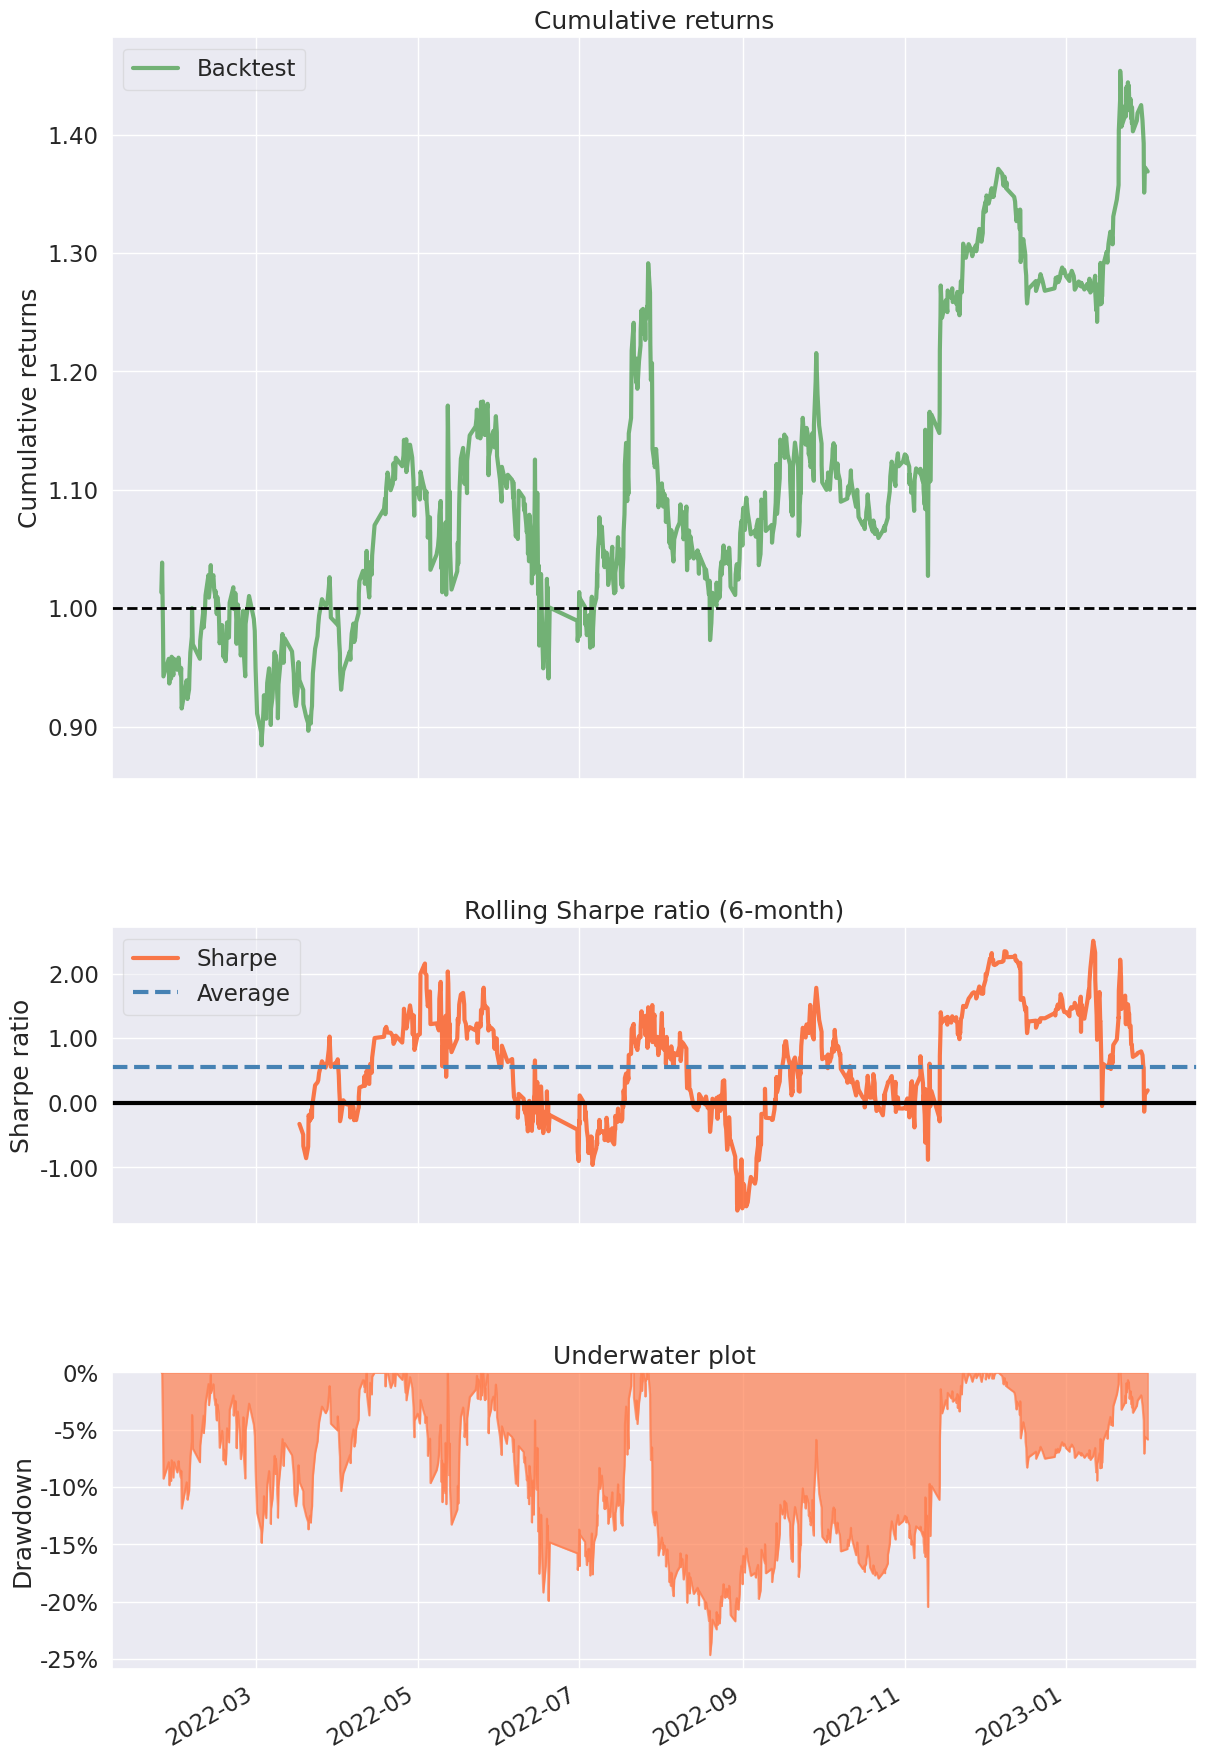

In [87]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [88]:
act_threshold = 0.55
act_ceil      = 0.6

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1
        if act_prob>=act_threshold and act_prob<=act_ceil:
            size = 0.5
        if act_prob>act_ceil:
            size = 1.0


        if position==1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-24 00:00:00
End                       2023-01-31 23:59:00
Duration                    372 days 23:59:00
Exposure Time [%]                    89.69113
Equity Final [$]             124363557.413339
Equity Peak [$]              127095348.252568
Return [%]                          24.363557
Buy & Hold Return [%]              -36.105452
Return (Ann.) [%]                     21.4859
Volatility (Ann.) [%]                24.62228
Sharpe Ratio                          0.87262
Sortino Ratio                        1.679282
Calmar Ratio                         1.213303
Max. Drawdown [%]                  -17.708607
Avg. Drawdown [%]                   -0.229713
Max. Drawdown Duration      143 days 01:48:00
Avg. Drawdown Duration        0 days 18:34:00
# Trades                                 1801
Win Rate [%]                        52.970572
Best Trade [%]                       5.613628
Worst Trade [%]                     -6.339686
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-01-31
Total months,85
,Backtest
Annual return,8.2%
Cumulative returns,75.8%
Annual volatility,21.0%
Sharpe ratio,0.48
Calmar ratio,0.19
Stability,0.53
Max drawdown,-42.4%


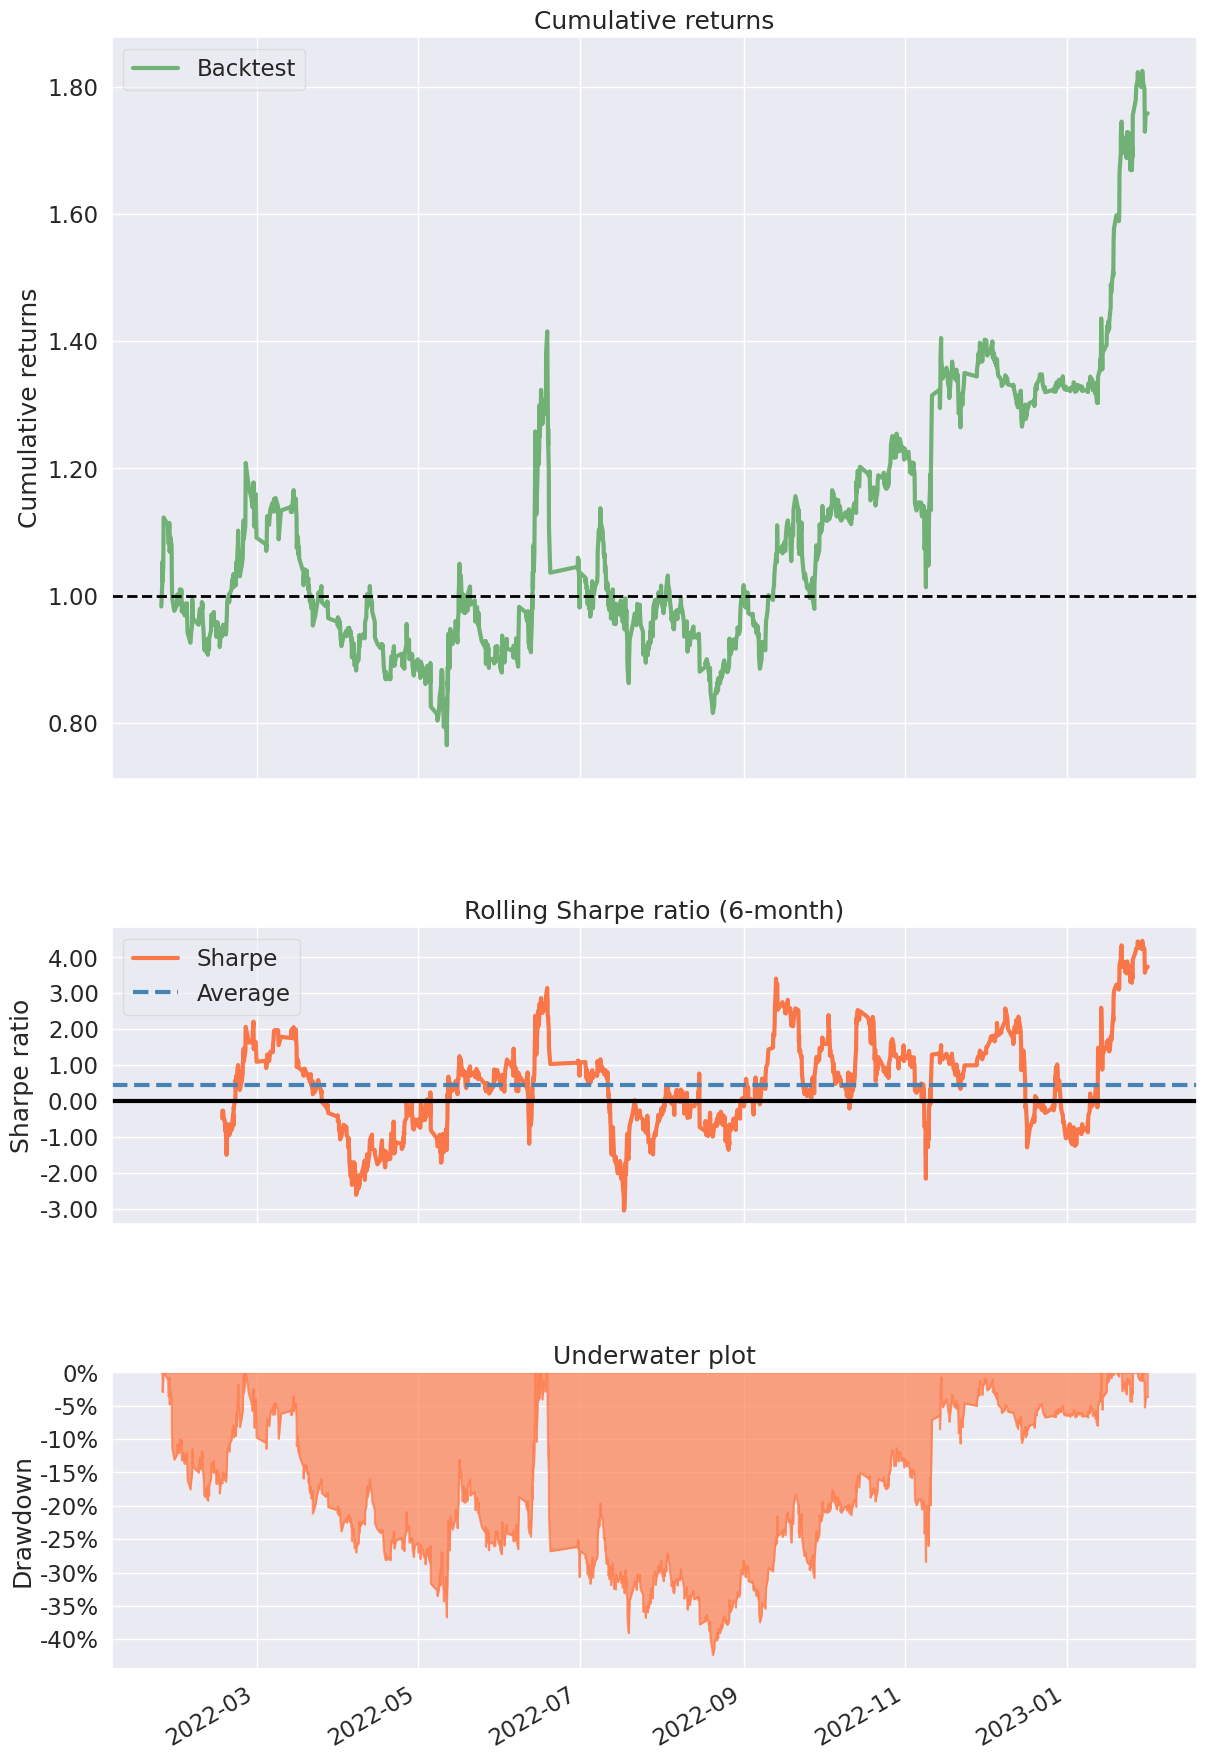

In [89]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [90]:
act_threshold = 0.6
act_ceil      = 0.7

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1
        if act_prob>=act_threshold and act_prob<=act_ceil:
            size = 0.5
        if act_prob>act_ceil:
            size = 1.0


        if position==1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-24 00:00:00
End                       2023-01-31 23:59:00
Duration                    372 days 23:59:00
Exposure Time [%]                   80.901847
Equity Final [$]             111587427.076572
Equity Peak [$]              114001911.459915
Return [%]                          11.587427
Buy & Hold Return [%]              -36.105452
Return (Ann.) [%]                   15.323495
Volatility (Ann.) [%]               29.272349
Sharpe Ratio                          0.52348
Sortino Ratio                         0.95207
Calmar Ratio                         0.819506
Max. Drawdown [%]                  -18.698451
Avg. Drawdown [%]                   -0.615344
Max. Drawdown Duration      263 days 00:58:00
Avg. Drawdown Duration        3 days 05:47:00
# Trades                                 1418
Win Rate [%]                        52.327221
Best Trade [%]                       5.587668
Worst Trade [%]                     -6.324063
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-01-31
Total months,67
,Backtest
Annual return,5.3%
Cumulative returns,33.9%
Annual volatility,22.2%
Sharpe ratio,0.34
Calmar ratio,0.17
Stability,0.29
Max drawdown,-32.0%


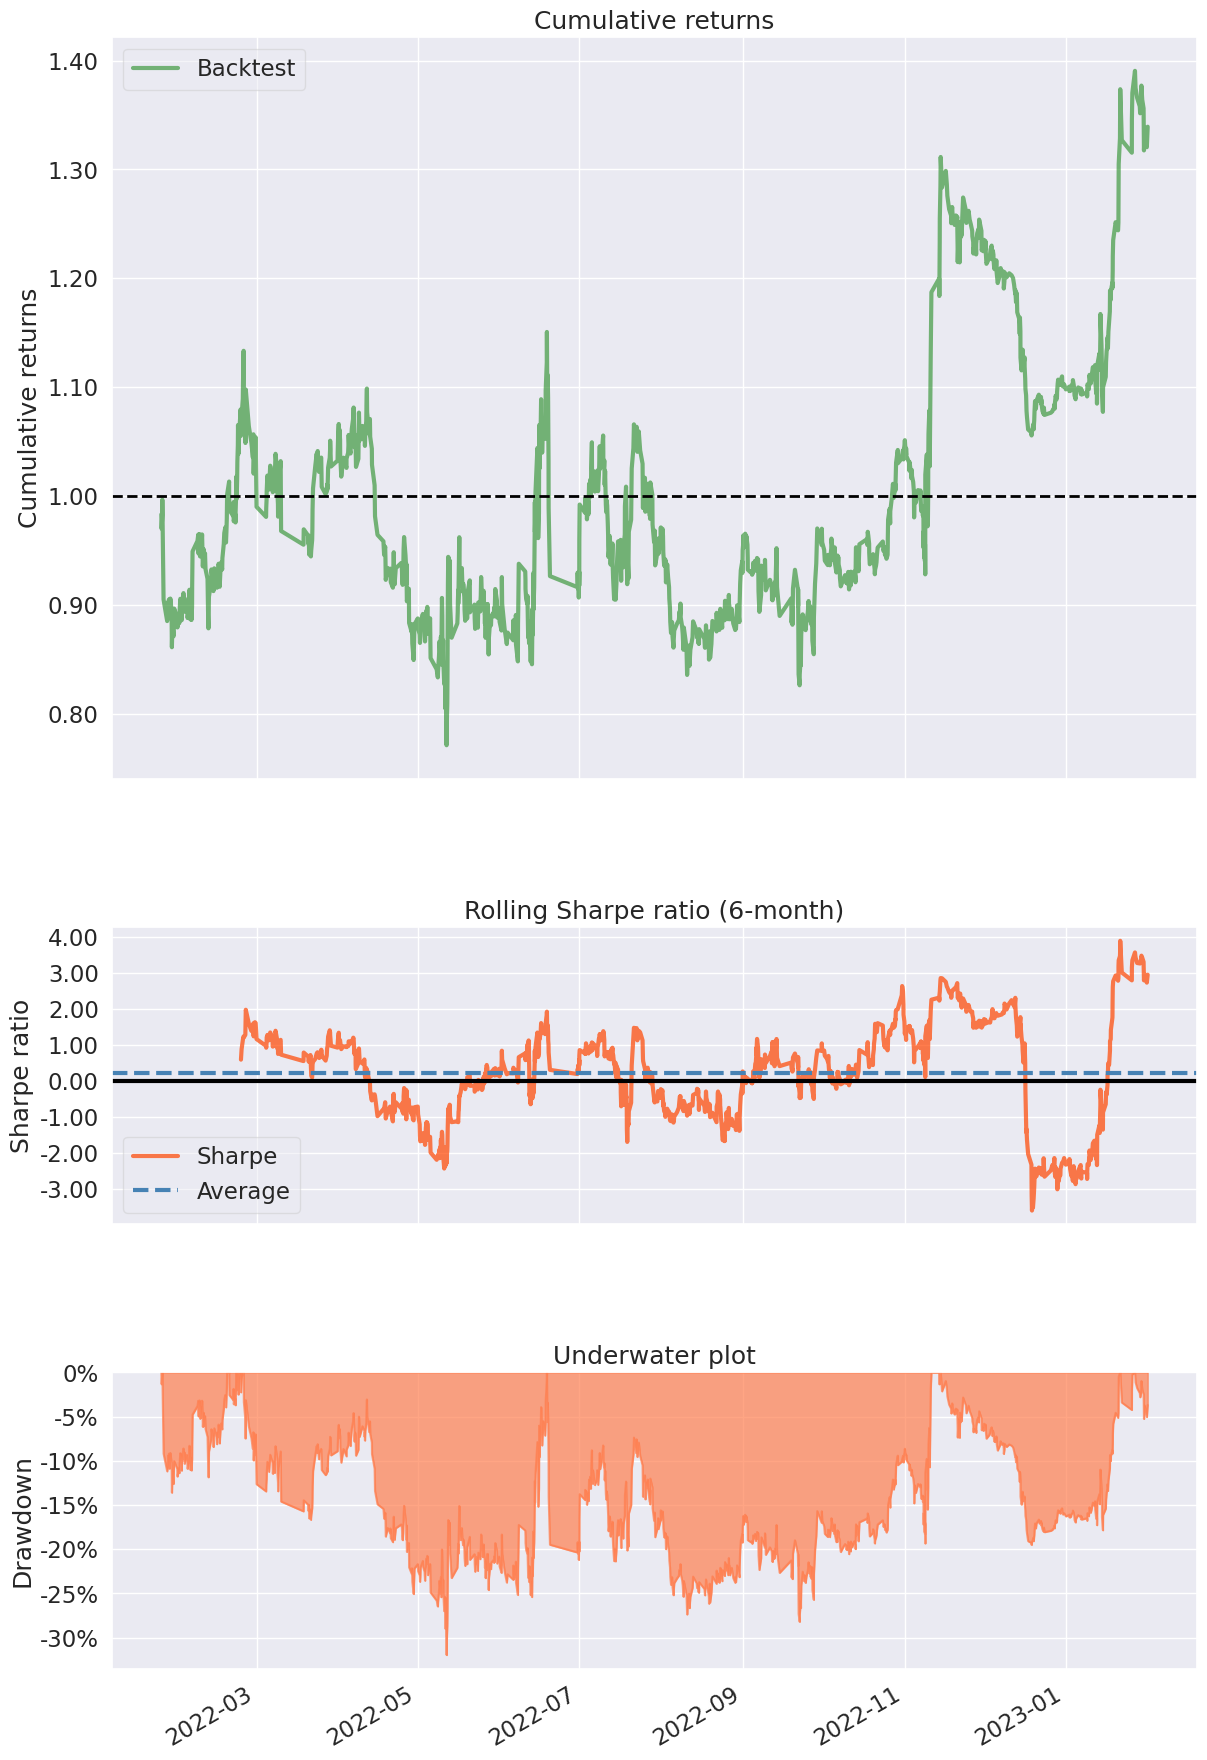

In [91]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [92]:
import os
import pickle
import joblib

os.makedirs("../model/", exist_ok=True)

In [93]:
# saving trained model
joblib.dump(rf_meta, "../model/btcusdt_rf_meta_rr1.save")

['../model/btcusdt_rf_meta_rr1.save']

In [94]:
features_string = " ".join(selected_cmda_features)
print(features_string)

with open("../model/features_meta_rr1.txt", "w") as f:
    f.write(features_string)

HT_DCPHASE t_dpo_50 m_wr_50 CORREL BBANDS_upperband t_macd_360_180 m_roc_120


In [95]:
loaded_rf = joblib.load("../model/btcusdt_rf_meta_rr1.save")

loaded_rf

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=15, n_estimators=512, n_jobs=-1,
                       random_state=42)